# JS-BSON and BSON-EXT Performance comparison

## Aim

The bson-ext library has been untouched for the better part of a year, but still has Over 10,000 weekly downloads. Its purpose was to provide a higher-performance bson serializer than the main bson serialization library in the Node ecosystem, js-bson, which is the library that we use internally in the Node driver. Due to a number of inconsistencies and the overhead of maintaning this additional library, the Node team intends to sunset this library. To get an understanding of where if anywhere js-bson needs to be improved to provide performance on-par with or better than bson-ext, we have undertaken the task of benchmarking both libraries.

## Methodology


## Results

In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import re
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = [9,6]

In [ ]:
import os
csvs = list(filter(lambda f: f.endswith('.csv'), os.listdir('../results')))
pprint(csvs)

In [294]:
documents = {}
# add stderr column
for csv in csvs:
    documents[csv] = pd.read_csv('../results/' + csv)
    documents[csv]['stderr'] = documents[csv]['stddev']/np.sqrt(documents[csv]['iterations'])

In [295]:
# Need to see bar charts for each test scenario grouped by bson version and relevant options
documents

{'regexResults.csv':                                  test_name         library         max  \
 0   regex_singleFieldDocument._deserialize      bson@6.2.0   13.377877   
 1   regex_singleFieldDocument._deserialize      bson@6.2.0   13.050566   
 2     regex_singleFieldDocument._serialize      bson@6.2.0   15.748056   
 3    regex_singleElementArray._deserialize      bson@6.2.0   11.709232   
 4    regex_singleElementArray._deserialize      bson@6.2.0   16.348853   
 5      regex_singleElementArray._serialize      bson@6.2.0   13.894255   
 6             regex_array_100._deserialize      bson@6.2.0   36.371900   
 7             regex_array_100._deserialize      bson@6.2.0   32.208047   
 8               regex_array_100._serialize      bson@6.2.0   71.431980   
 9              regex_array_10._deserialize      bson@6.2.0   33.690928   
 10             regex_array_10._deserialize      bson@6.2.0   29.881046   
 11               regex_array_10._serialize      bson@6.2.0   58.317186   
 12  

In [398]:
# UTILITIES
BAR_LABEL_CONFIG = {
    'rotation': 'vertical',
    'label_type': 'center',
    'padding': 3
    
}

def filterFor(df, testSpec,
              promoteValues='-',
              promoteLongs='-',
              promoteBuffers='-',
              useBigInt64='-',
              checkKeys='-',
              ignoreUndefined='-',
              bsonRegExp='-',
              utf8Validation='-'):
    if promoteValues != '-':
        df = df[df['promoteValues'] == promoteValues]
    if promoteLongs != '-':
        df = df[df['promoteLongs'] == promoteLongs]
    if promoteBuffers != '-':
        df = df[df['promoteBuffers'] == promoteBuffers]
    if useBigInt64 != '-':
        df = df[df['useBigInt64'] == useBigInt64]
    if checkKeys != '-':
        df = df[df['checkKeys'] == checkKeys]
    if ignoreUndefined != '-':
        df = df[df['ignoreUndefined'] == ignoreUndefined]
    if bsonRegExp != '-':
        df = df[df['bsonRegExp'] == bsonRegExp]
    if utf8Validation != '-':
        df = df[df['utf8Validation'] == utf8Validation]
        
    return df[df['test_name'].str.contains(testSpec)]


def createSimpleGraph(df, testSpec, title,
                      promoteValues='-',
                      promoteLongs='-',
                      promoteBuffers='-',
                      useBigInt64='-',
                      checkKeys='-',
                      ignoreUndefined='-',
                      bsonRegExp='-',
                      utf8Validation='-'):
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    
    results = filterFor(df, testSpec, **kwargs)
    width = 0.25
    versions = results['library'].values
    fix, ax = plt.subplots()

    x = np.arange(len(versions))
    rects = ax.bar(x, results['mean'])

    ax.set_ylabel('Throughput (MB/s)')
    ax.set_title(title)
    ax.set_xticks(x, versions)
    plt.grid(True)
     
    plt.savefig('simpleGraph__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()
    
def createSimpleGraphPct(df, testSpec, title,
                         promoteValues='-',
                         promoteLongs='-',
                         promoteBuffers='-',
                         useBigInt64='-',
                         checkKeys='-',
                         ignoreUndefined='-',
                         bsonRegExp='-',
                         utf8Validation='-'):
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    results = addPercentImprovementOverBSONEXT(filterFor(df, testSpec,**kwargs))
    width = 0.25
    versions = results['library'].values
    fix, ax = plt.subplots()

    x = np.arange(len(versions))
    rects = ax.bar(x, results['pctImprovementOverBsonExt']* 100)

    ax.set_ylabel('% speedup over bson-ext')
    ax.set_title(title)
    ax.set_xticks(x, versions)
    plt.grid(True)
    
    plt.savefig('simpleGraphPct__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()

def addPercentImprovementOverBSONEXT(df):
    relevantRow = df[df['library'].str.contains('bson-ext')]
    if len(relevantRow) > 1:
        raise ValueError('dataframe not constrained enough')
    if len(relevantRow) == 0:
        raise ValueError('dataframe overconstrained')
    mean = relevantRow['mean'].values[0]
    col = df.apply(lambda r: (r['mean'] - mean)/mean, axis=1)
    return df.assign(pctImprovementOverBsonExt=col.values)
    

def createArrayGraph(df, operation, title,
                     promoteValues='-',
                     promoteLongs='-',
                     promoteBuffers='-',
                     useBigInt64='-',
                     checkKeys='-',
                     ignoreUndefined='-',
                     bsonRegExp='-',
                     utf8Validation='-',
                     ylim=100):
    
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    
    array10Results = filterFor(df, 'array_10._'+operation, **kwargs)
    array100Results = filterFor(df, 'array_100._'+operation, **kwargs)
    array1000Results = filterFor(df, 'array_1000._'+operation,**kwargs)
    versions = array10Results['library'].values

    measurements = {
        10: array10Results,
        100: array100Results,
        1000: array1000Results
    }

    #print(array10Results)
    x = np.arange(len(versions))
    # map version to n=10,n=100, n=1000 results
    results = {}
    for __n in [10, 100, 1000]:
        results[__n] = []

    for version in array10Results['library']:
        for n, res in measurements.items():
            results[n].append(res.loc[res['library'] == version, 'mean'].values[0])


    width = 0.25
    mult = 0
    fig, ax1 = plt.subplots()
    for _n, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=f"n={_n}")
        ax1.bar_label(rects, **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('Throughput (MB/s)')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(0, ylim)

    plt.xticks(rotation=45)
    plt.savefig('arrayGraph__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()
    
    
def createArrayGraphPct(df, operation, title,
                     promoteValues='-',
                     promoteLongs='-',
                     promoteBuffers='-',
                     useBigInt64='-',
                     checkKeys='-',
                     ignoreUndefined='-',
                     bsonRegExp='-',
                     utf8Validation='-',
                     ylim0=-45,
                     ylim1=100):
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    kwargs = {
        'promoteValues': promoteValues,
        'promoteLongs': promoteLongs,
        'promoteBuffers': promoteBuffers,
        'useBigInt64': useBigInt64,
        'checkKeys': checkKeys,
        'ignoreUndefined': ignoreUndefined,
        'bsonRegExp': bsonRegExp,
        'utf8Validation': utf8Validation
    }
    array10Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_10._'+operation, **kwargs))
    array100Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_100._'+operation, **kwargs))
    array1000Results = addPercentImprovementOverBSONEXT(filterFor(df, 'array_1000._'+operation, **kwargs))

    versions = array10Results['library'].values

    measurements = {
        10: array10Results,
        100: array100Results,
        1000: array1000Results
    }

    #print(array10Results)
    x = np.arange(len(versions))
    # map version to n=10,n=100, n=1000 results
    results = {}
    for __n in [10, 100, 1000]:
        results[__n] = []

    for version in array10Results['library']:
        for n, res in measurements.items():
            results[n].append(res.loc[res['library'] == version, 'pctImprovementOverBsonExt'].values[0]*100)


    width = 0.25
    mult = 0
    fig, ax1 = plt.subplots()
    for _n, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=f"n={_n}")
        ax1.bar_label(rects, fmt='%.3f', **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('% speedup over bson-ext')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(ylim0, ylim1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('arrayGraphPct__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()
    
def createMixedGraphs(df, operation, title, ylim0=0, ylim1=100):
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    
    smallResults = filterFor(df, 'mixed_small._'+operation)
    mediumResults = filterFor(df, 'mixed_medium._'+operation)
    largeResults = filterFor(df, 'mixed_large._'+operation)
    tweetResults = filterFor(df, 'tweet._'+operation)
    bestbuyResults = filterFor(df, 'bestbuy_medium._'+operation)
    deepBsonResults = filterFor(df, 'deep_bson._'+operation)
    flatBsonResults = filterFor(df, 'flat_bson._'+operation)
    fullBsonResults = filterFor(df, 'full_bson._'+operation)
    nested4Results = filterFor(df, 'nested_4._'+operation)
    nested8Results = filterFor(df, 'nested_8._'+operation)
    nested16Results = filterFor(df, 'nested_16._'+operation)
    
    versions = tweetResults['library'].values
    
    measurements = {
        'mixed_small': smallResults,
        'mixed_medium': mediumResults,
        'mixed_large': largeResults,
        'tweet': tweetResults,
        'bestbuy_medium': bestbuyResults,
        'deepBson': deepBsonResults,
        'flatBson': flatBsonResults,
        'fullBson': fullBsonResults,
        'nested4': nested4Results,
        'nested8': nested8Results,
        'nested16': nested16Results    
    }
    
    x = np.arange(len(versions))
    results = {}
    for __n in measurements.keys():
        results[__n] = []


    for version in versions:
        for n, res in measurements.items():
            values = res.loc[res['library'] == version, 'mean'].values
            if len(values) > 0:
                results[n].append(values[0])
            else:
                results[n].append(0)
    

    width = 0.075
    mult = 0
    fig, ax1 = plt.subplots()
    for size, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=size)
        ax1.bar_label(rects, fmt='%.3f', **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('Throughput (MB/s)')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(ylim0, ylim1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('mixedGraph__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()
    
def createMixedGraphsPct(df, operation, title, ylim0=0, ylim1=100):
    if operation != 'serialize' and operation != 'deserialize':
        raise ValueError('Invalid operation')
    
    smallResults = addPercentImprovementOverBSONEXT(filterFor(df, 'mixed_small._'+operation))
    mediumResults = addPercentImprovementOverBSONEXT(filterFor(df, 'mixed_medium._'+operation))
    largeResults = addPercentImprovementOverBSONEXT(filterFor(df, 'mixed_large._'+operation))
    tweetResults = addPercentImprovementOverBSONEXT(filterFor(df, 'tweet._'+operation))
    bestbuyResults = addPercentImprovementOverBSONEXT(filterFor(df, 'bestbuy_medium._'+operation))
    deepBsonResults = addPercentImprovementOverBSONEXT(filterFor(df, 'deep_bson._'+operation))
    flatBsonResults = addPercentImprovementOverBSONEXT(filterFor(df, 'flat_bson._'+operation))
    fullBsonResults = addPercentImprovementOverBSONEXT(filterFor(df, 'full_bson._'+operation))
    nested4Results = addPercentImprovementOverBSONEXT(filterFor(df, 'nested_4._'+operation))
    nested8Results = addPercentImprovementOverBSONEXT(filterFor(df, 'nested_8._'+operation))
    nested16Results = addPercentImprovementOverBSONEXT(filterFor(df, 'nested_16._'+operation))
    
    versions = tweetResults['library'].values
    
    measurements = {
        'mixed_small': smallResults,
        'mixed_medium': mediumResults,
        'mixed_large': largeResults,
        'tweet': tweetResults,
        'bestbuy_medium': bestbuyResults,
        'deepBson': deepBsonResults,
        'flatBson': flatBsonResults,
        'fullBson': fullBsonResults,
        'nested4': nested4Results,
        'nested8': nested8Results,
        'nested16': nested16Results    
    }
    
    x = np.arange(len(versions))
    results = {}
    for __n in measurements.keys():
        results[__n] = []

    for version in versions:
        for n, res in measurements.items():
            value = res.loc[res['library'] == version, 'pctImprovementOverBsonExt'].values[0]*100
            results[n].append(value)

    width = 0.075
    mult = 0
    fig, ax1 = plt.subplots()
    for size, measurement in results.items():
        offset = width * mult
        rects = ax1.bar(x+offset, measurement, width, label=size)
        ax1.bar_label(rects, fmt='%.3f', **BAR_LABEL_CONFIG)
        mult += 1

    ax1.set_ylabel('% speedup over bson-ext')
    ax1.set_title(title)
    ax1.set_xticks(x+width, versions)
    ax1.legend(loc='upper left', ncols=len(versions))
    ax1.set_ylim(ylim0, ylim1)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.savefig('mixedGraphPct__' + title.replace(' ', '_')+'.png', bbox_inches='tight')
    plt.show()

# Long Results

## Deserialize

### Array

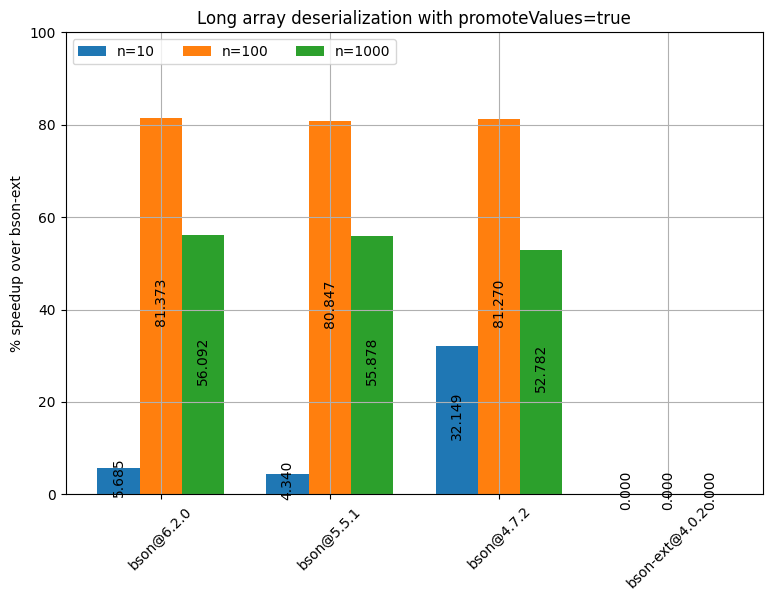

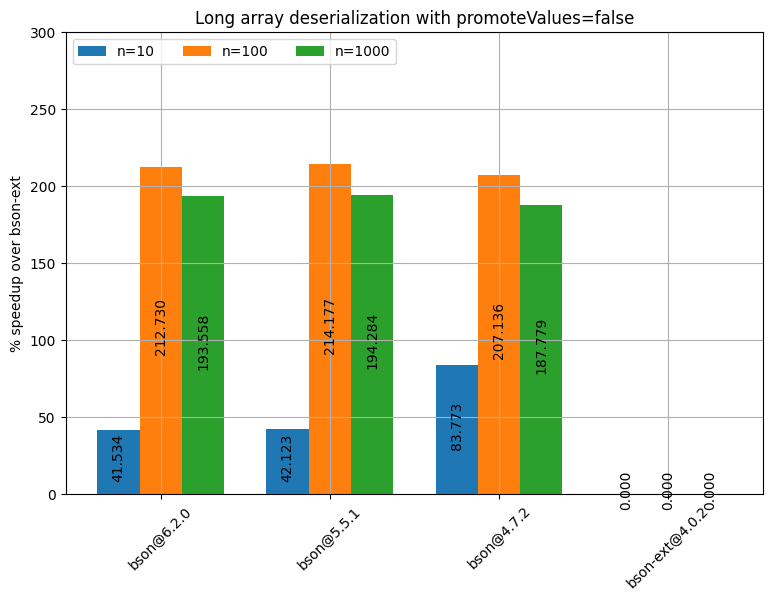

In [297]:
createArrayGraphPct(documents['longResults.csv'], 'deserialize', 'Long array deserialization with promoteValues=true', promoteValues='1', ylim0=0 )
createArrayGraphPct(documents['longResults.csv'], 'deserialize', 'Long array deserialization with promoteValues=false', promoteValues='0', ylim0=0, ylim1=300 )

### Single element Array and Single Field document

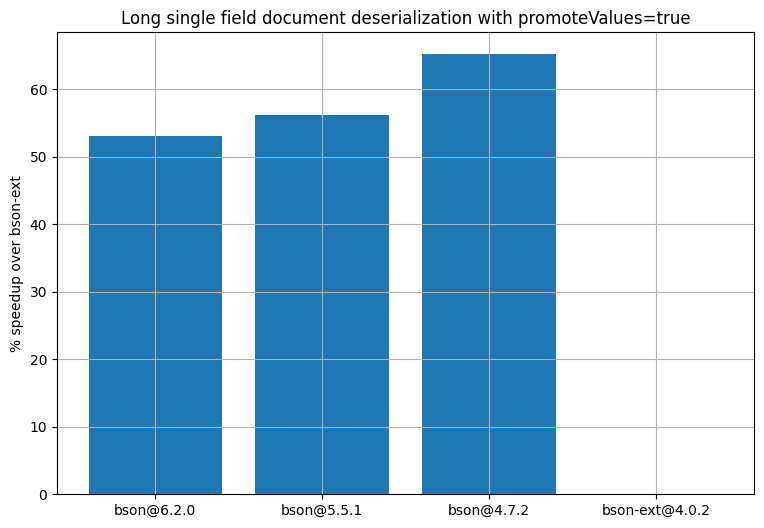

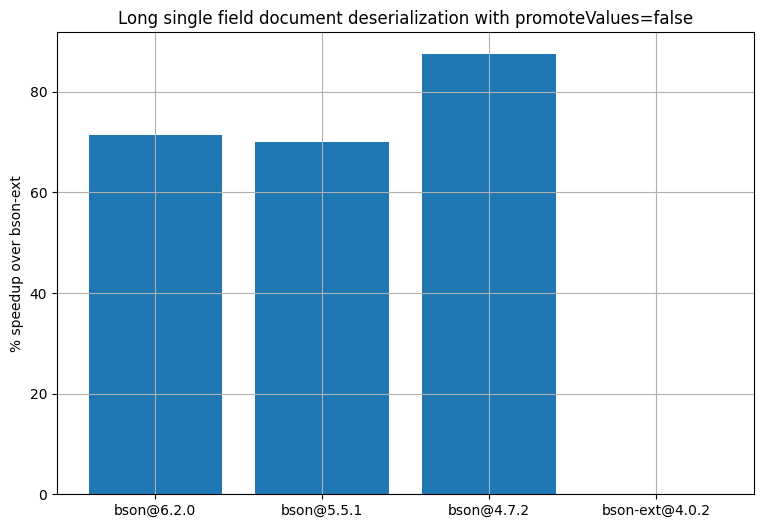

In [298]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleFieldDocument._deserialize', 'Long single field document deserialization with promoteValues=true', promoteValues='1')
createSimpleGraphPct(longResults, '_singleFieldDocument._deserialize', 'Long single field document deserialization with promoteValues=false', promoteValues='0')

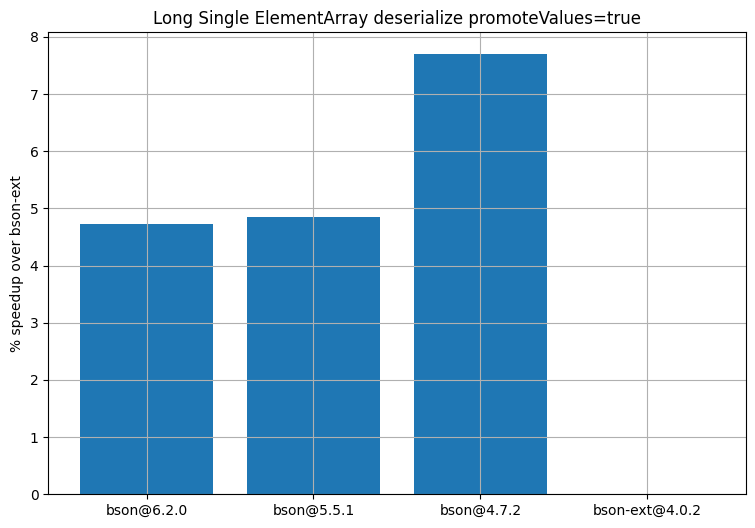

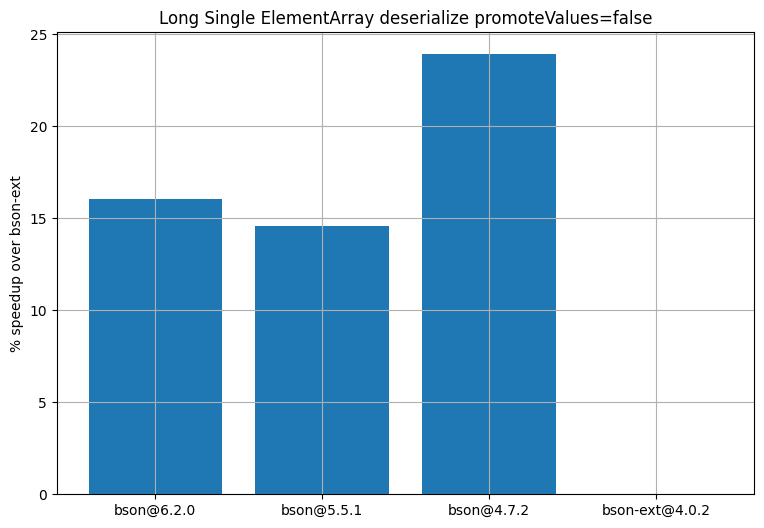

In [299]:
longResults = documents['longResults.csv']
createSimpleGraphPct(longResults, '_singleElementArray._deserialize', 'Long Single ElementArray deserialize promoteValues=true', promoteValues='1')
createSimpleGraphPct(longResults, '_singleElementArray._deserialize', 'Long Single ElementArray deserialize promoteValues=false', promoteValues='0')

## Serialize

### Array

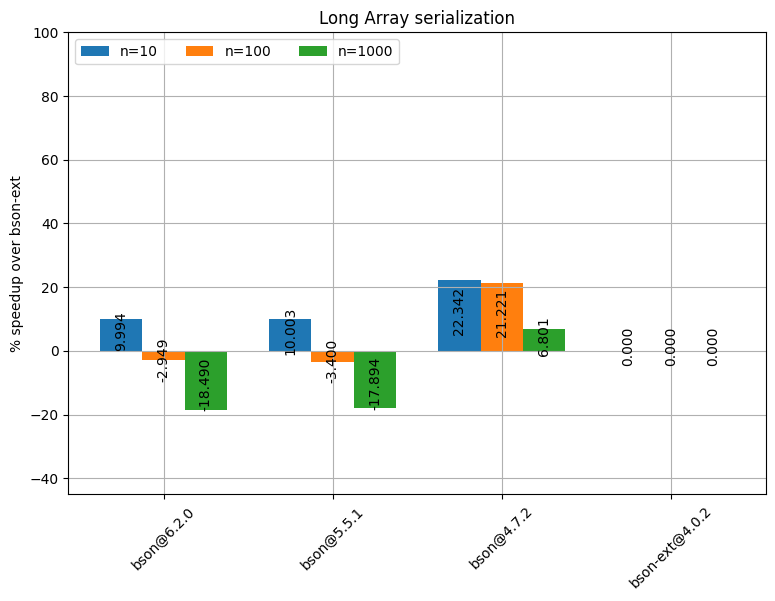

In [300]:
createArrayGraphPct(documents['longResults.csv'], 'serialize', 'Long Array serialization')

### Single element and single field

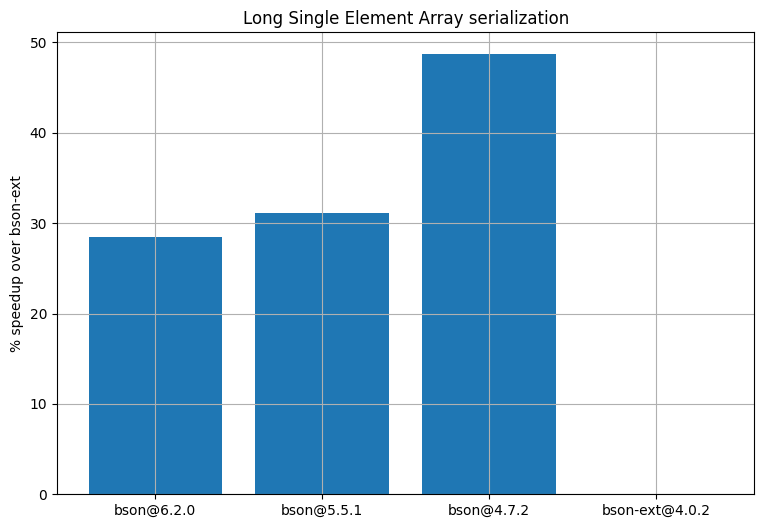

In [301]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleElementArray._serialize', 'Long Single Element Array serialization')

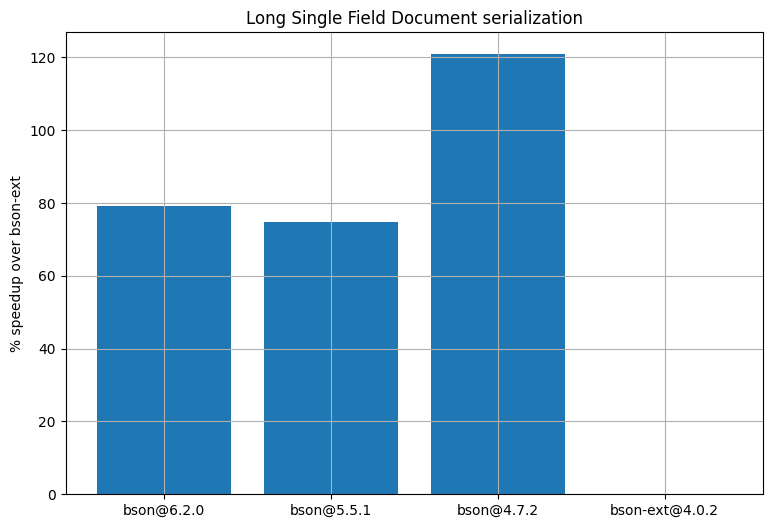

In [302]:
longResults = documents['longResults.csv']

createSimpleGraphPct(longResults, '_singleFieldDocument._serialize', 'Long Single Field Document serialization')

# Double

## Serialize

### Single Field Document and Single Element Array

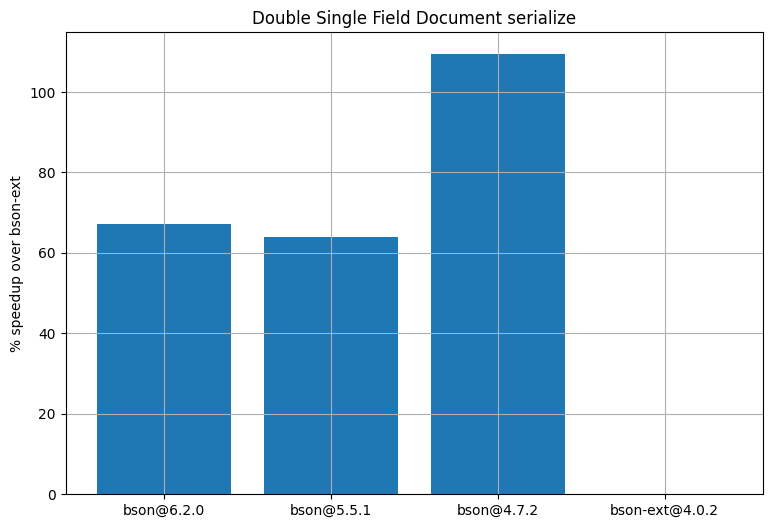

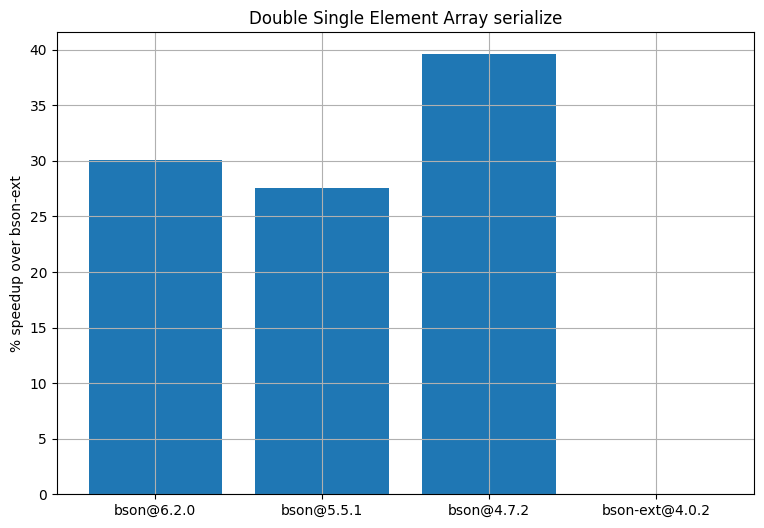

In [303]:
doubleResults = documents['doubleResults.csv']
createSimpleGraphPct(doubleResults, '_singleFieldDocument._serialize', 'Double Single Field Document serialize')
createSimpleGraphPct(doubleResults, '_singleElementArray._serialize', 'Double Single Element Array serialize')


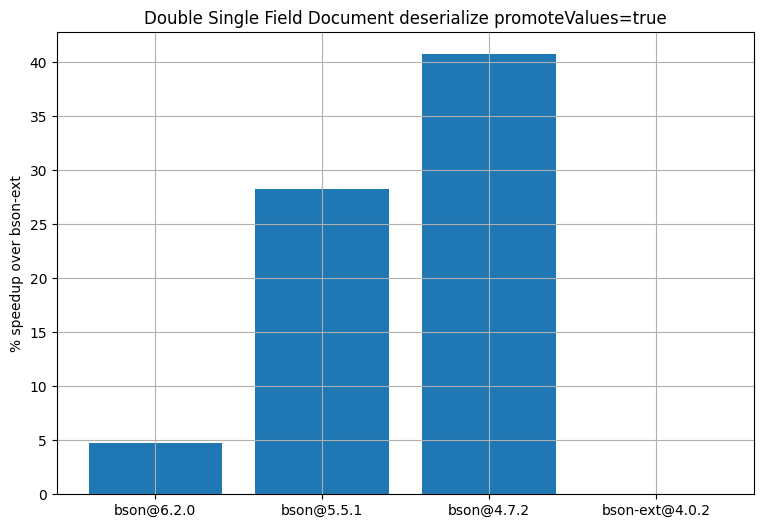

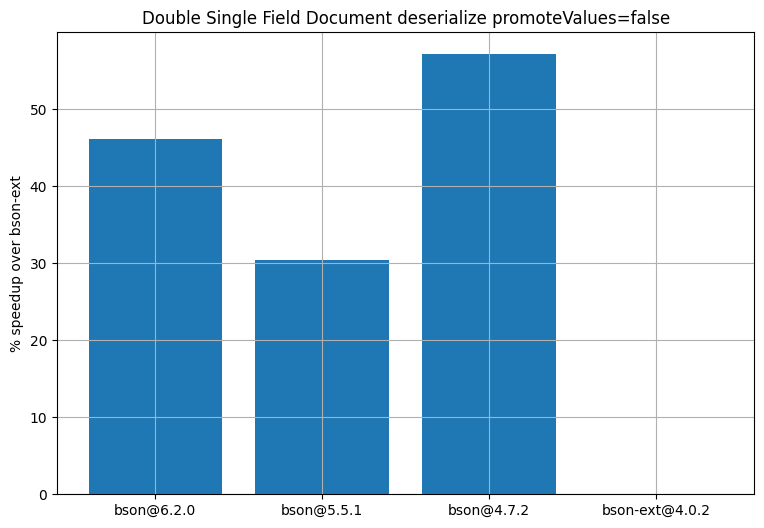

In [304]:
createSimpleGraphPct(doubleResults, '_singleFieldDocument._deserialize', 'Double Single Field Document deserialize promoteValues=true', promoteValues='1')
createSimpleGraphPct(doubleResults, '_singleFieldDocument._deserialize', 'Double Single Field Document deserialize promoteValues=false', promoteValues='0')

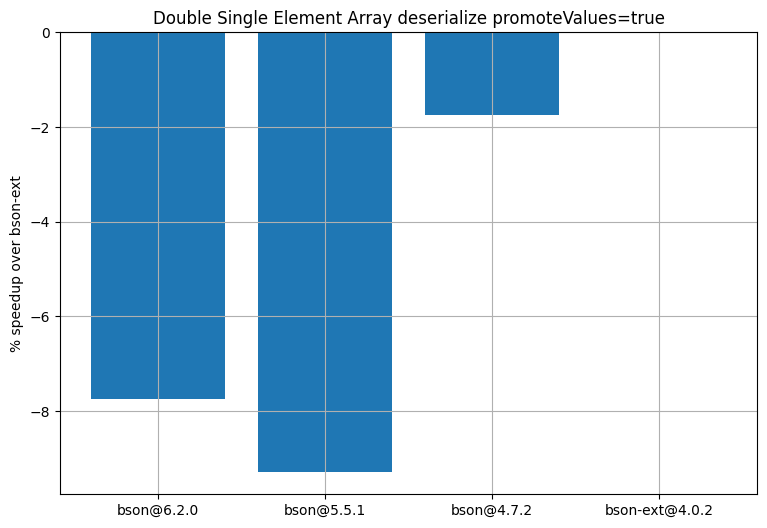

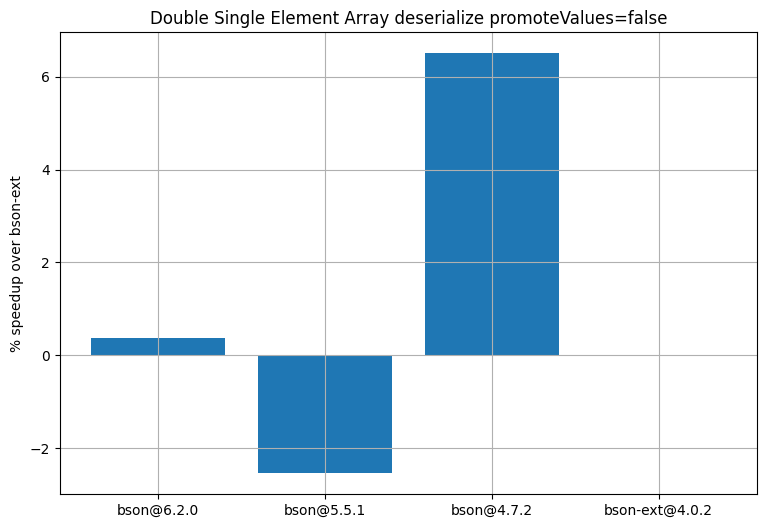

In [305]:

createSimpleGraphPct(doubleResults, '_singleElementArray._deserialize', 'Double Single Element Array deserialize promoteValues=true', promoteValues='1')
createSimpleGraphPct(doubleResults, '_singleElementArray._deserialize', 'Double Single Element Array deserialize promoteValues=false', promoteValues='0')

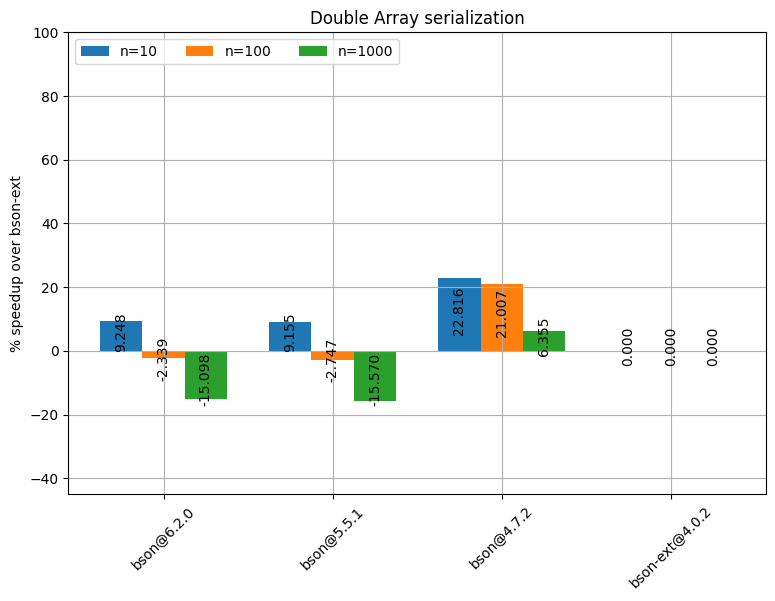

In [306]:
createArrayGraphPct(documents['doubleResults.csv'], 'serialize', 'Double Array serialization')

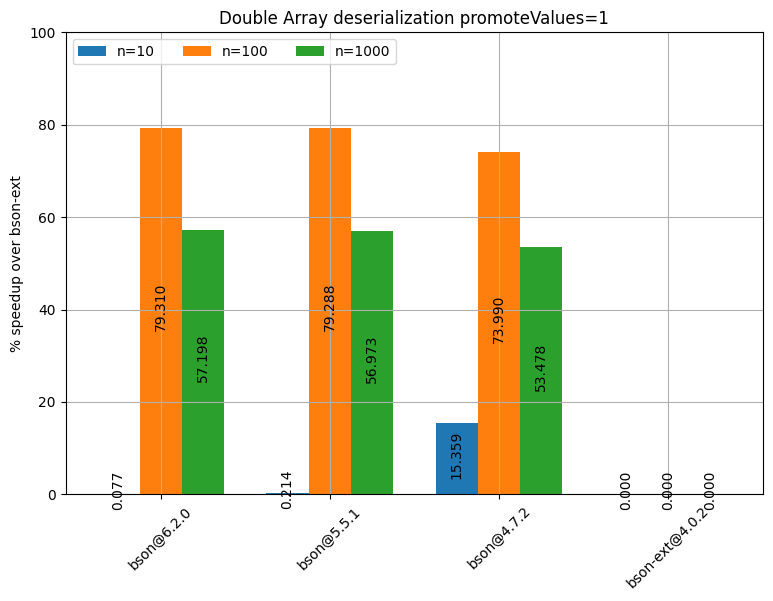

In [307]:
createArrayGraphPct(documents['doubleResults.csv'], 'deserialize', 'Double Array deserialization promoteValues=1', promoteValues='1', ylim0=0)


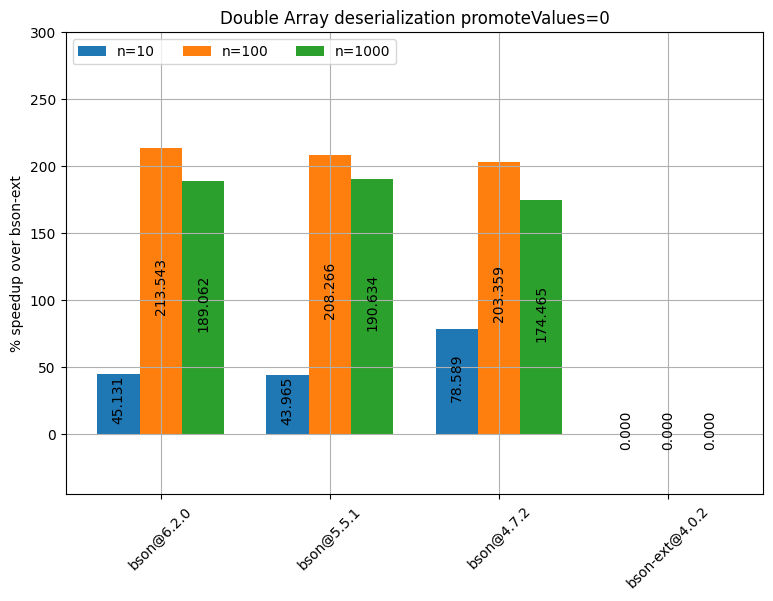

In [308]:
createArrayGraphPct(documents['doubleResults.csv'], 'deserialize', 'Double Array deserialization promoteValues=0', promoteValues='0', ylim1=300)


In [309]:
# Date
dateResults = documents['dateResults.csv']

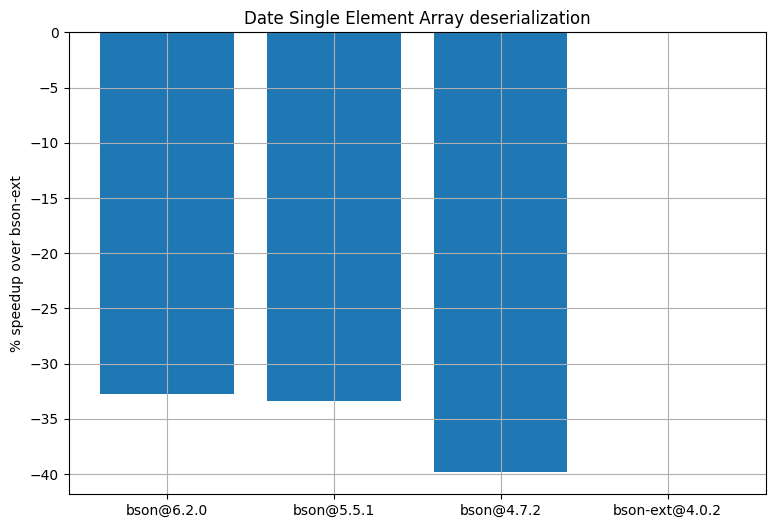

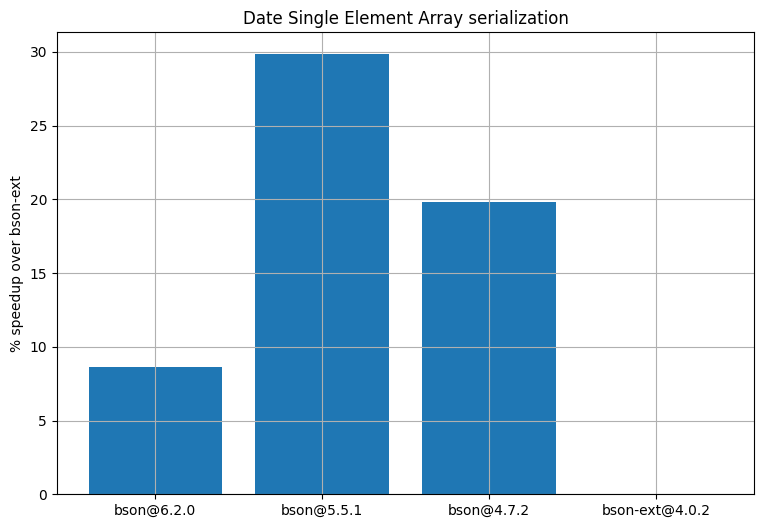

In [369]:
## Single element Array
createSimpleGraphPct(dateResults, '_singleElementArray._deserialize', 'Date Single Element Array deserialization')

createSimpleGraphPct(dateResults, '_singleElementArray._serialize', 'Date Single Element Array serialization')

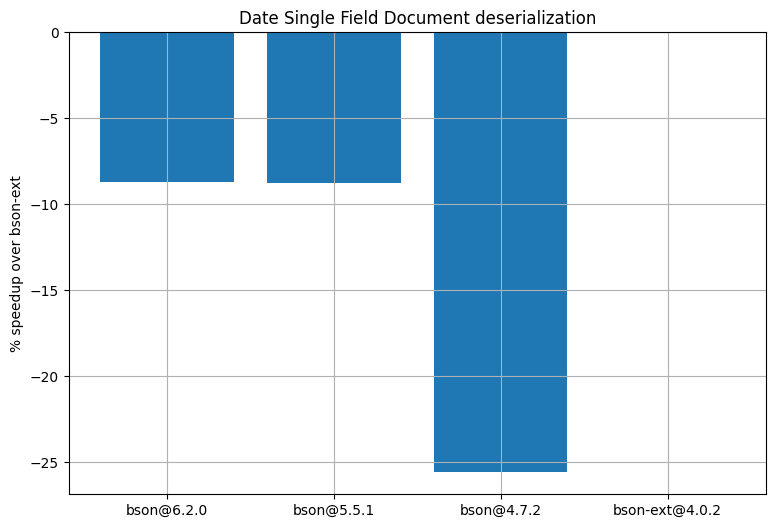

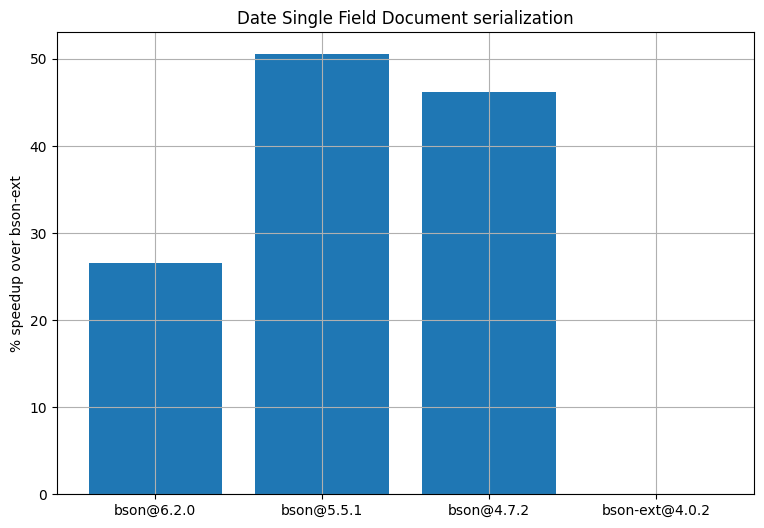

In [372]:
## Single field document
createSimpleGraphPct(dateResults, '_singleFieldDocument._deserialize', 'Date Single Field Document deserialization')

createSimpleGraphPct(dateResults, '_singleFieldDocument._serialize', 'Date Single Field Document serialization')

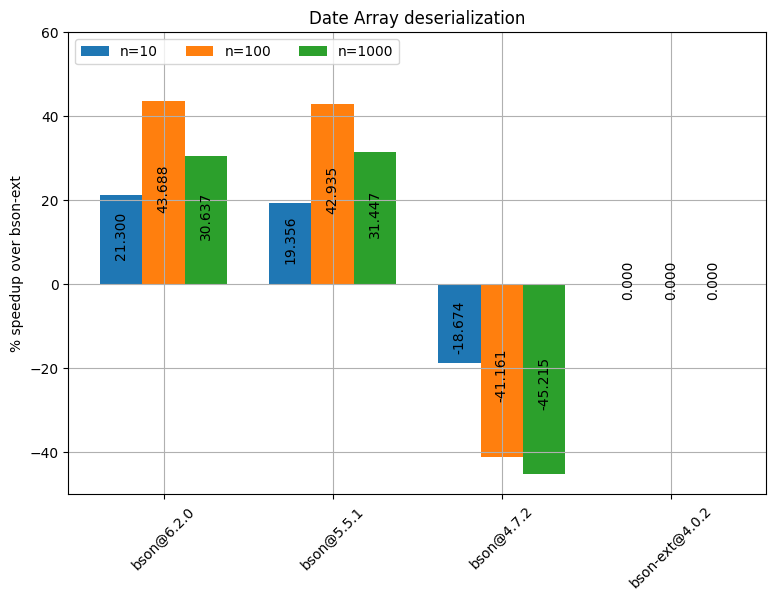

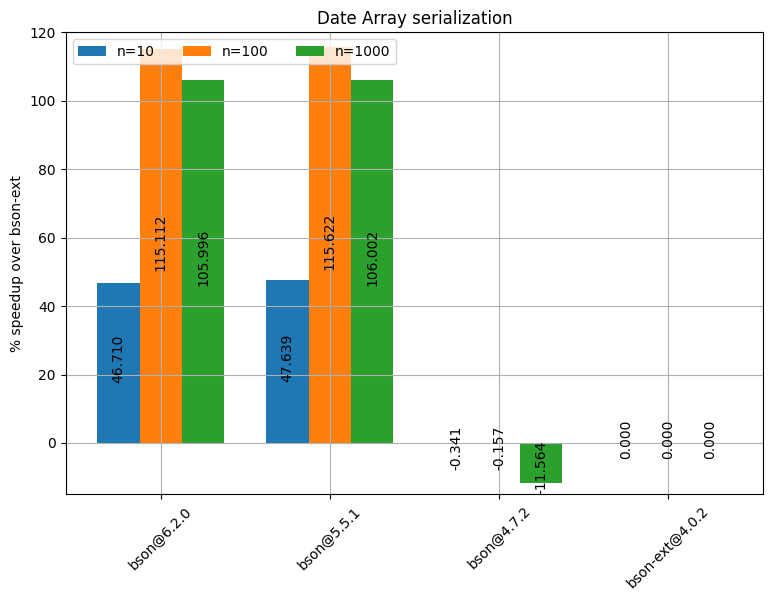

In [368]:
## Array
createArrayGraphPct(dateResults, 'deserialize', 'Date Array deserialization', ylim0=-50, ylim1=60)
createArrayGraphPct(dateResults, 'serialize', 'Date Array serialization', ylim0=-15, ylim1=120)

In [313]:
# Null
nullResults = documents['nullResults.csv']

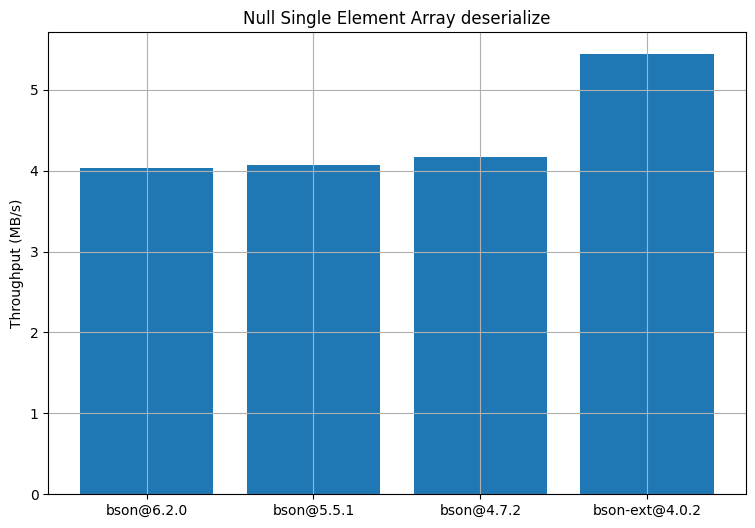

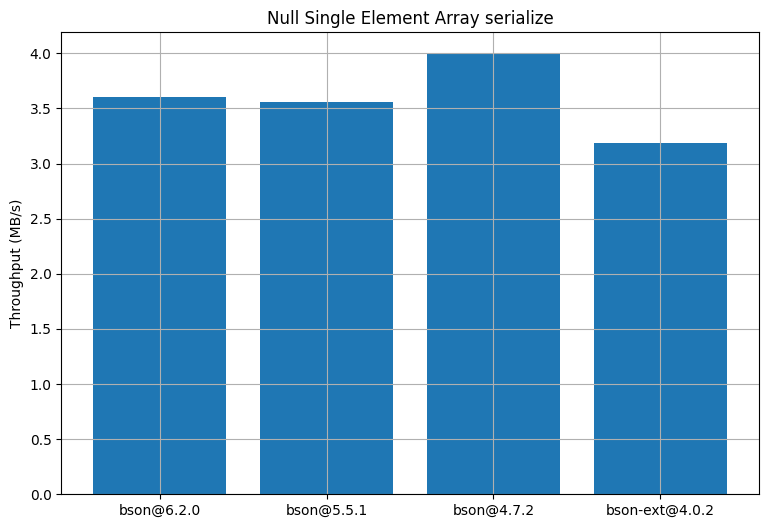

In [314]:
## Single element Array
createSimpleGraph(nullResults, '_singleElementArray._deserialize', 'Null Single Element Array deserialize')

createSimpleGraph(nullResults, '_singleElementArray._serialize', 'Null Single Element Array serialize')

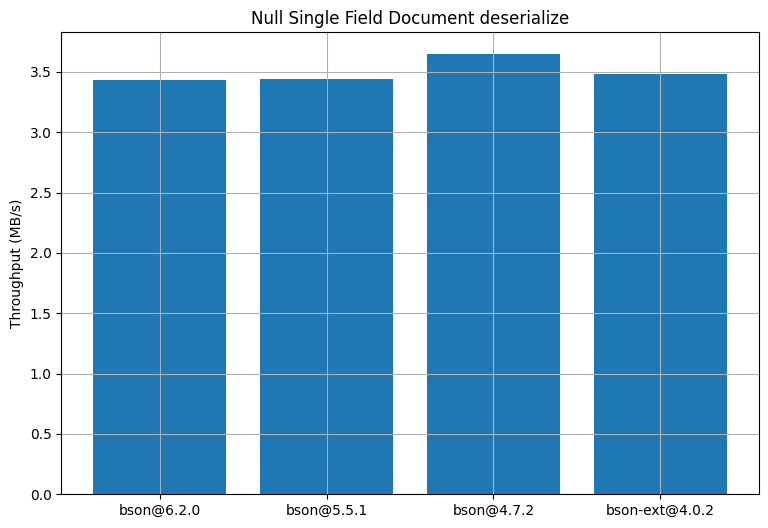

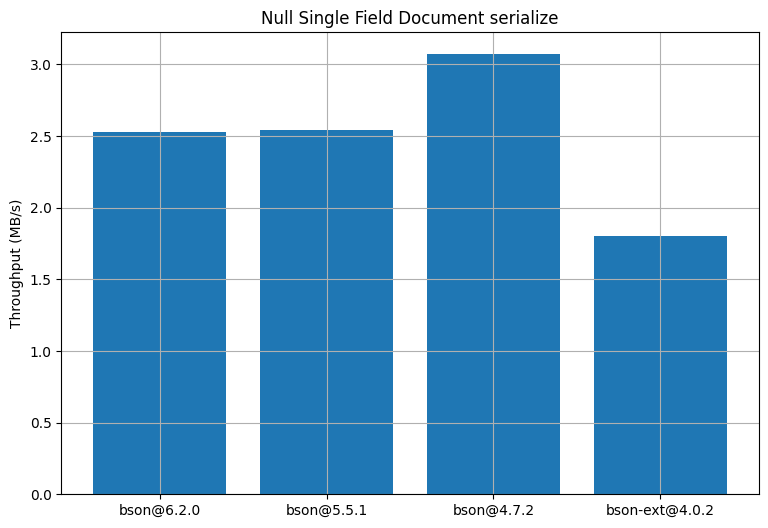

In [315]:
## Single field document
createSimpleGraph(nullResults, '_singleFieldDocument._deserialize', 'Null Single Field Document deserialize')

createSimpleGraph(nullResults, '_singleFieldDocument._serialize', 'Null Single Field Document serialize')

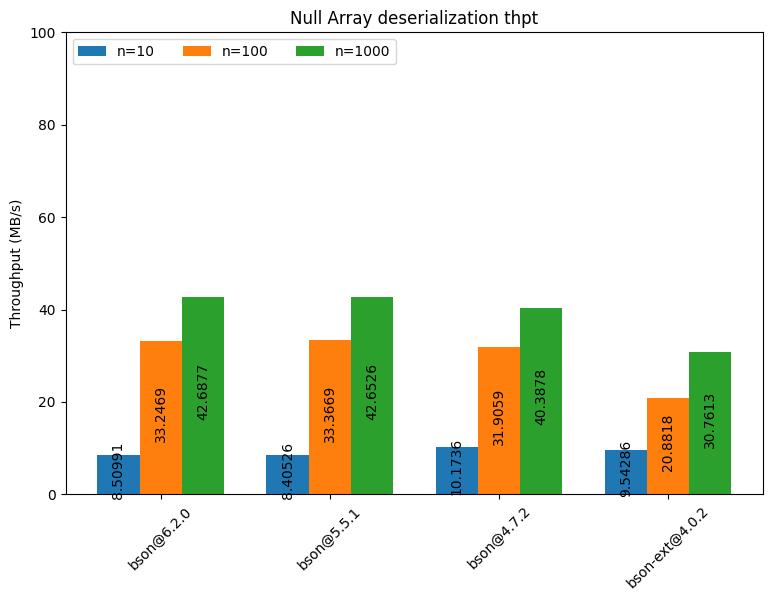

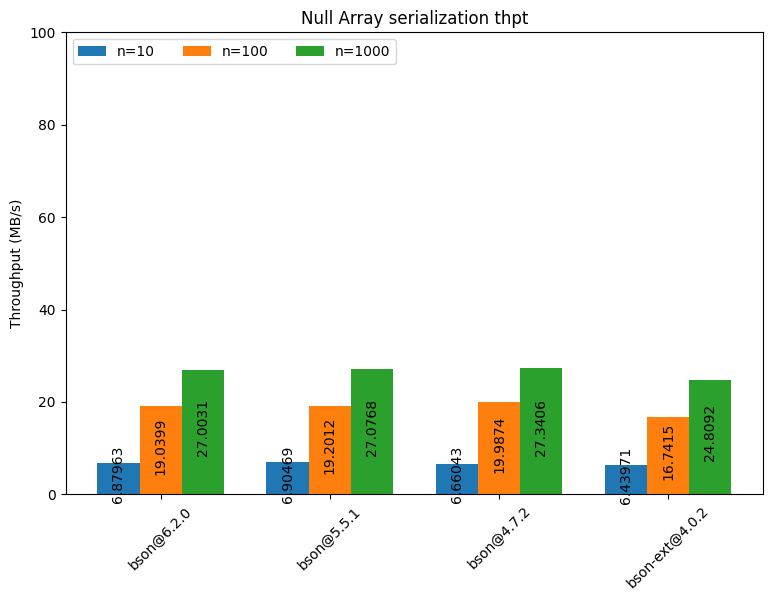

In [316]:
## Array
createArrayGraph(nullResults, 'deserialize', 'Null Array deserialization thpt')
createArrayGraph(nullResults, 'serialize', 'Null Array serialization thpt')

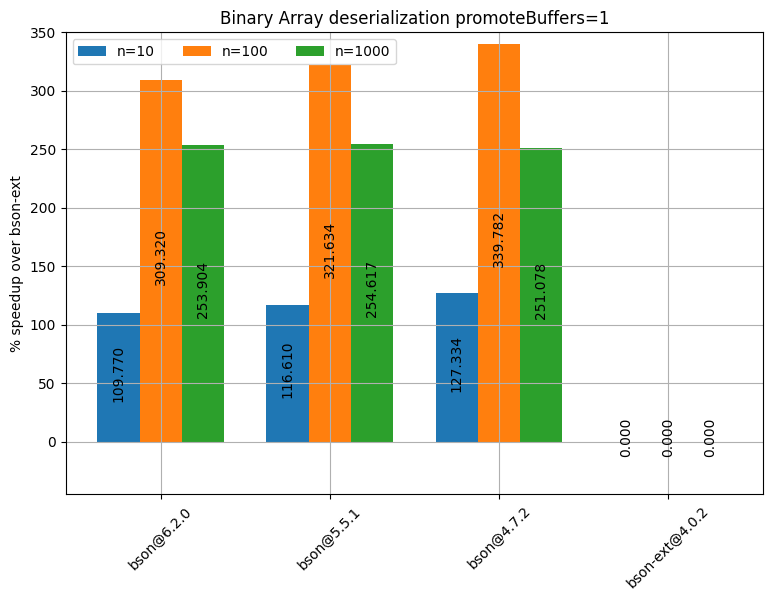

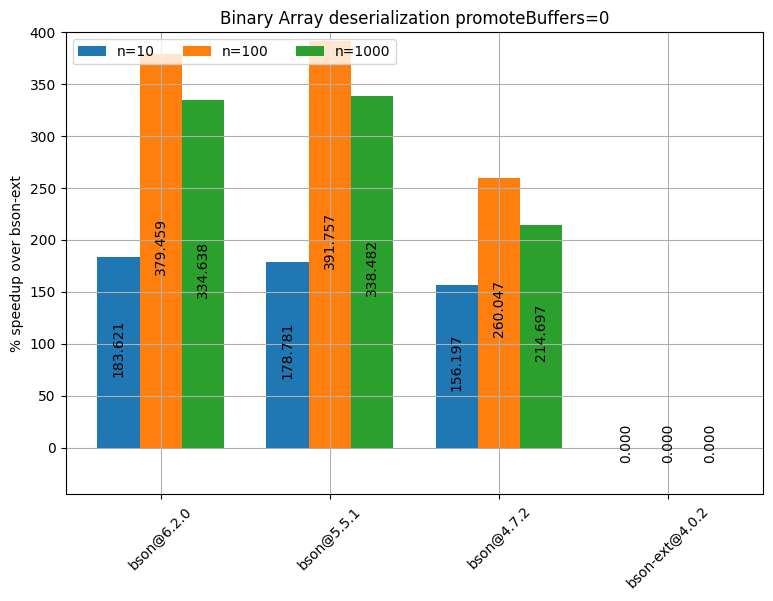

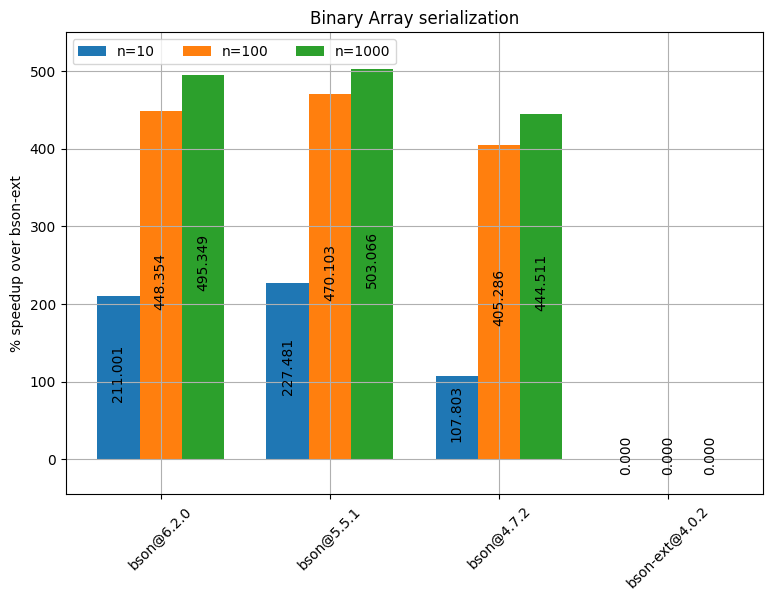

In [324]:
# Binary
binaryResults = documents['binaryResults.csv']
createArrayGraphPct(binaryResults, 'deserialize', 'Binary Array deserialization promoteBuffers=1', promoteBuffers='1', ylim1=350)
createArrayGraphPct(binaryResults, 'deserialize', 'Binary Array deserialization promoteBuffers=0', promoteBuffers='0', ylim1=400)

createArrayGraphPct(binaryResults, 'serialize', 'Binary Array serialization', ylim1=550)

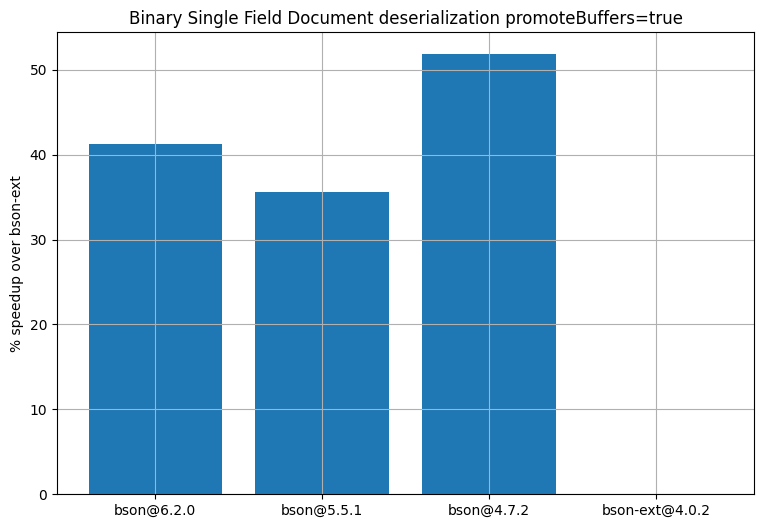

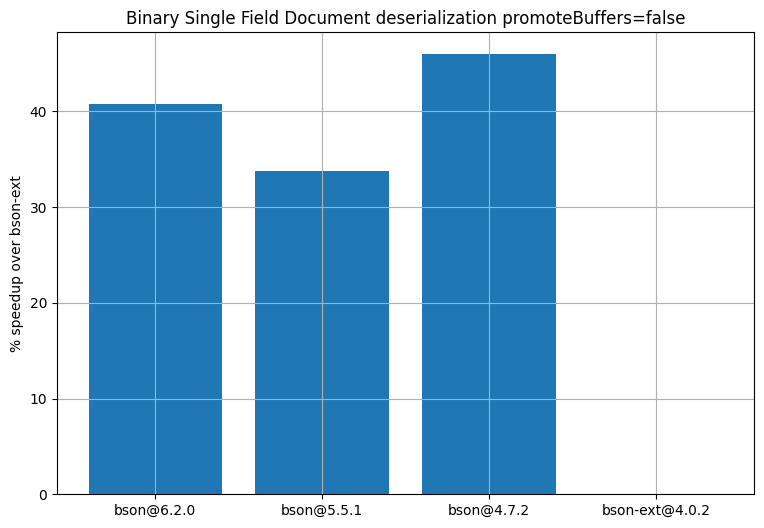

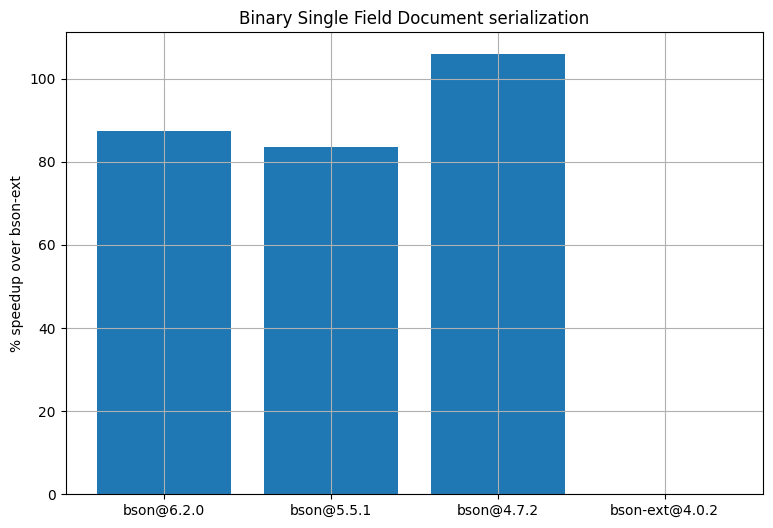

In [387]:
## Single Field Document

createSimpleGraphPct(binaryResults, '_singleFieldDocument._deserialize', 'Binary Single Field Document deserialization promoteBuffers=true', promoteBuffers='1')
createSimpleGraphPct(binaryResults, '_singleFieldDocument._deserialize', 'Binary Single Field Document deserialization promoteBuffers=false', promoteBuffers='0')

createSimpleGraphPct(binaryResults, '_singleFieldDocument._serialize', 'Binary Single Field Document serialization')

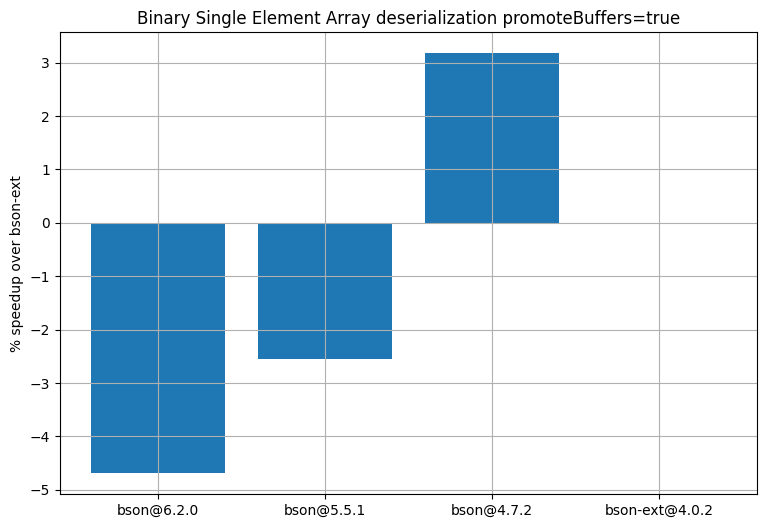

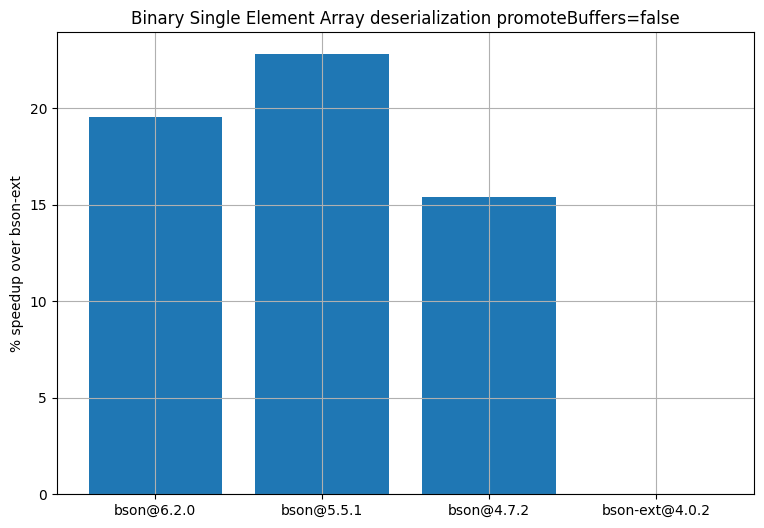

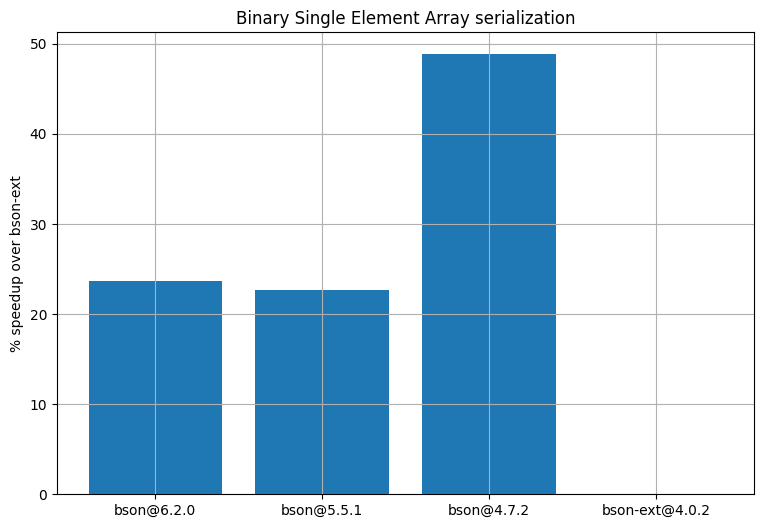

In [388]:
## Single Element Array
createSimpleGraphPct(binaryResults, '_singleElementArray._deserialize', 'Binary Single Element Array deserialization promoteBuffers=true', promoteBuffers='1')
createSimpleGraphPct(binaryResults, '_singleElementArray._deserialize', 'Binary Single Element Array deserialization promoteBuffers=false', promoteBuffers='0')

createSimpleGraphPct(binaryResults, '_singleElementArray._serialize', 'Binary Single Element Array serialization')

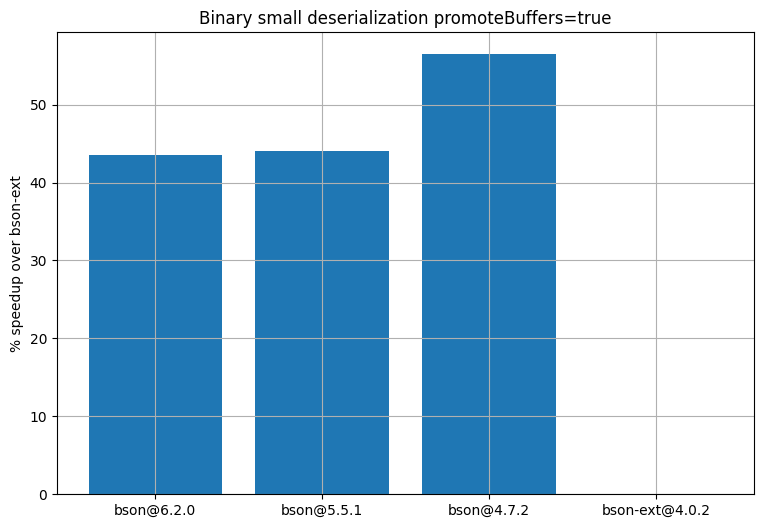

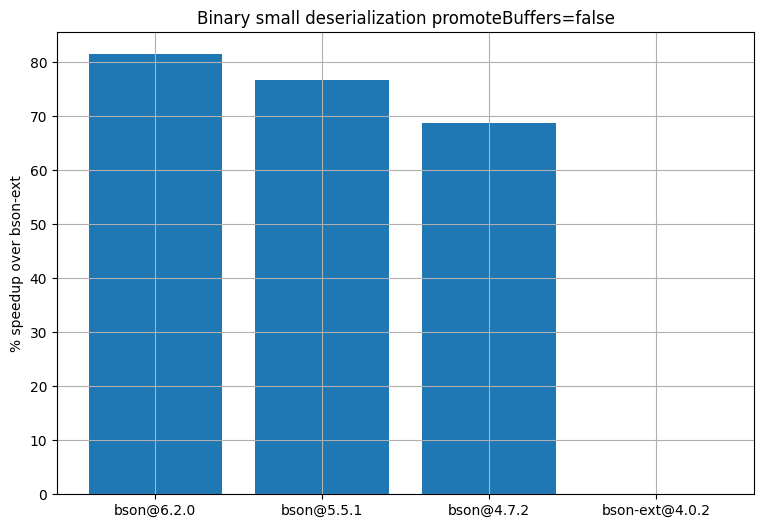

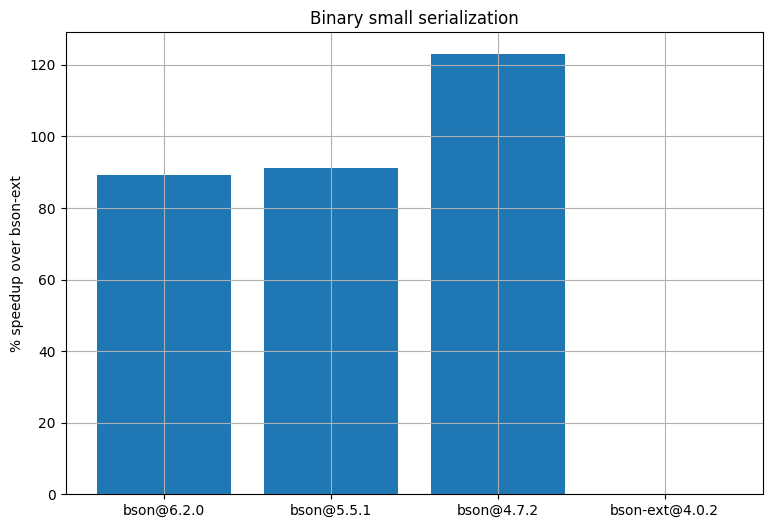

In [390]:
## small
createSimpleGraphPct(binaryResults, '_small._deserialize', 'Binary small deserialization promoteBuffers=true', promoteBuffers='1')
createSimpleGraphPct(binaryResults, '_small._deserialize', 'Binary small deserialization promoteBuffers=false', promoteBuffers='0')

createSimpleGraphPct(binaryResults, '_small._serialize', 'Binary small serialization')

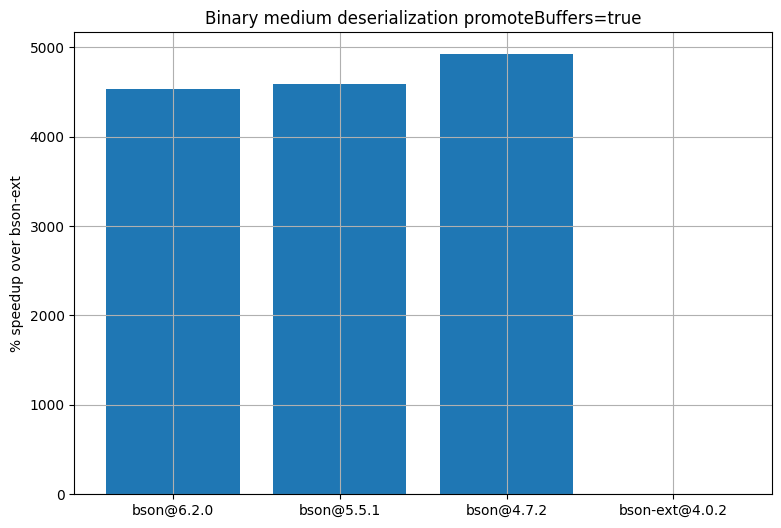

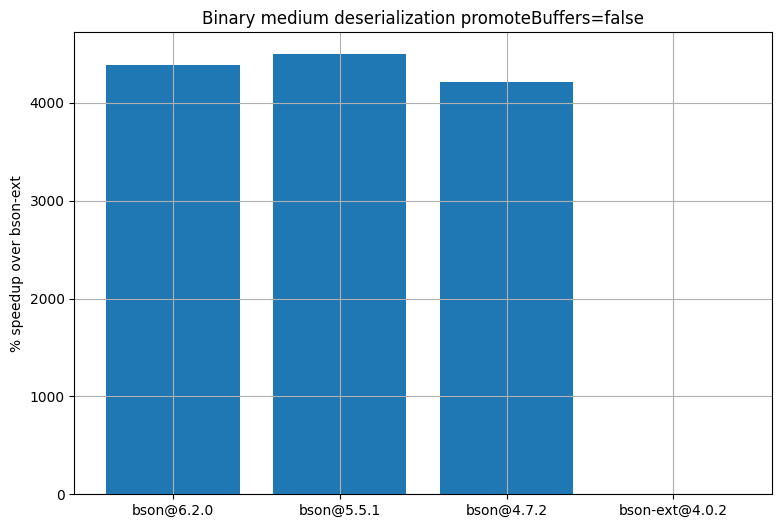

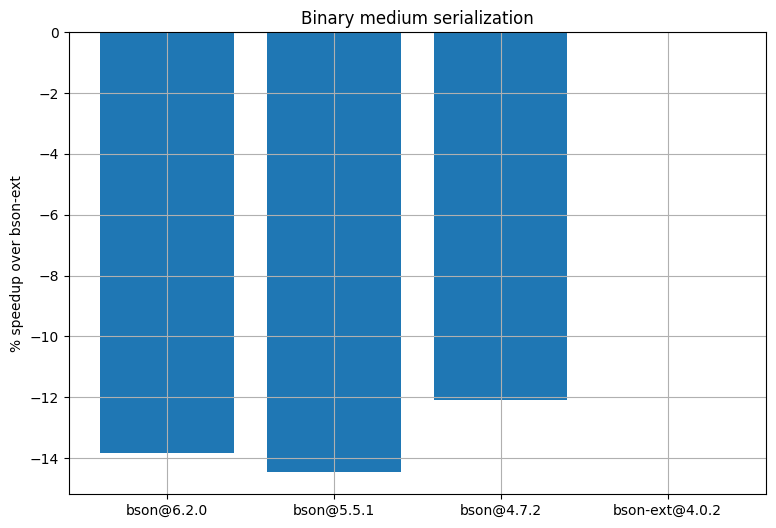

In [389]:
createSimpleGraphPct(binaryResults, '_medium._deserialize', 'Binary medium deserialization promoteBuffers=true', promoteBuffers='1')
createSimpleGraphPct(binaryResults, '_medium._deserialize', 'Binary medium deserialization promoteBuffers=false', promoteBuffers='0')

createSimpleGraphPct(binaryResults, '_medium._serialize', 'Binary medium serialization')

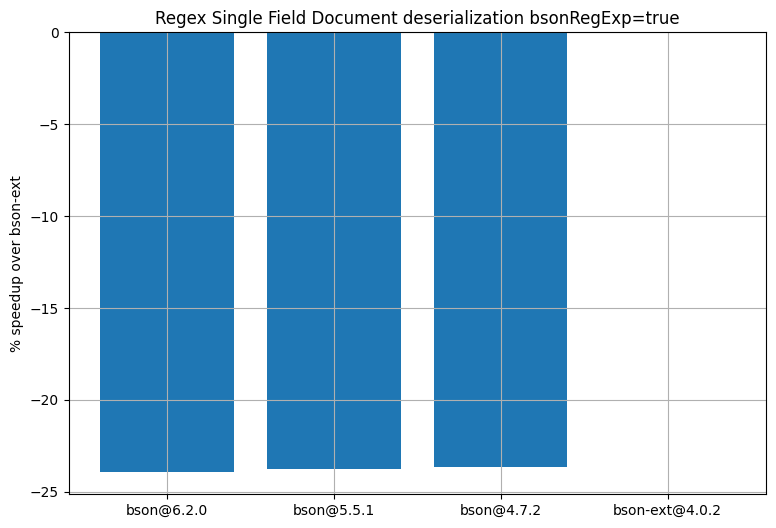

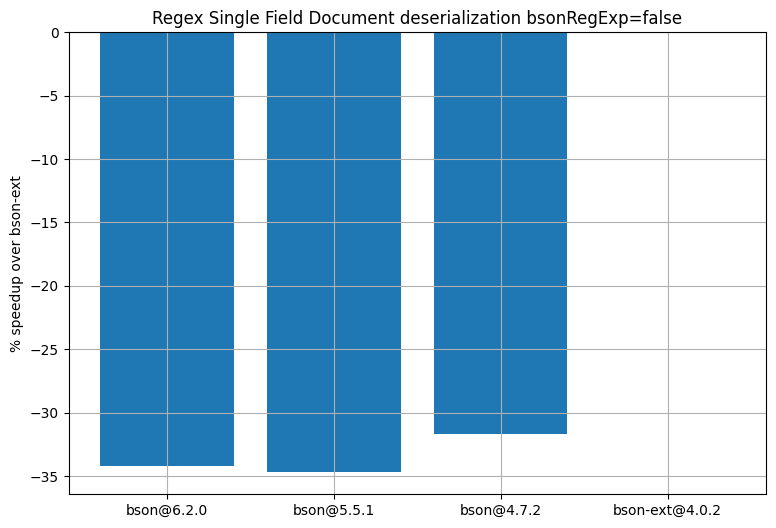

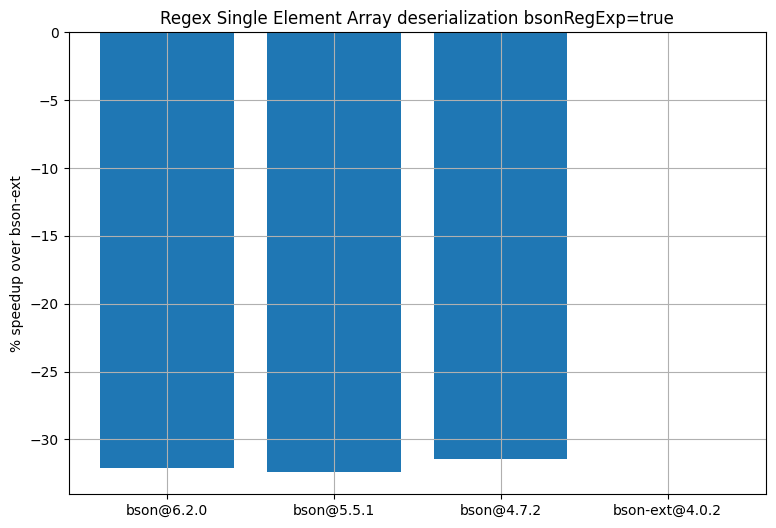

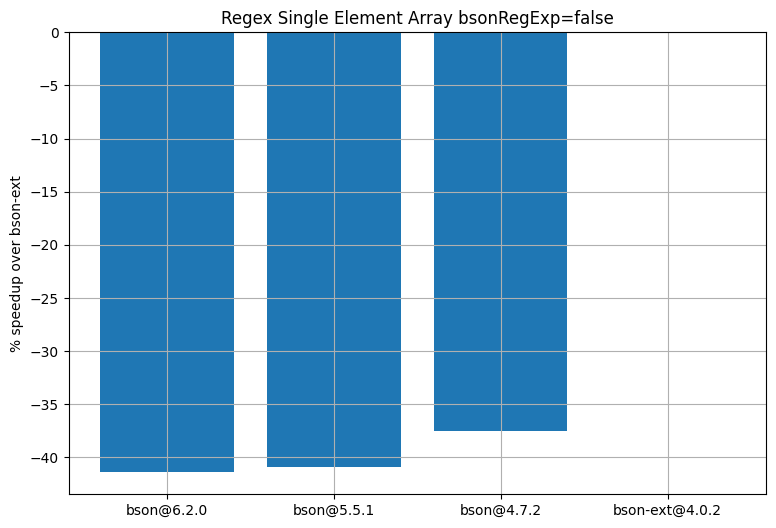

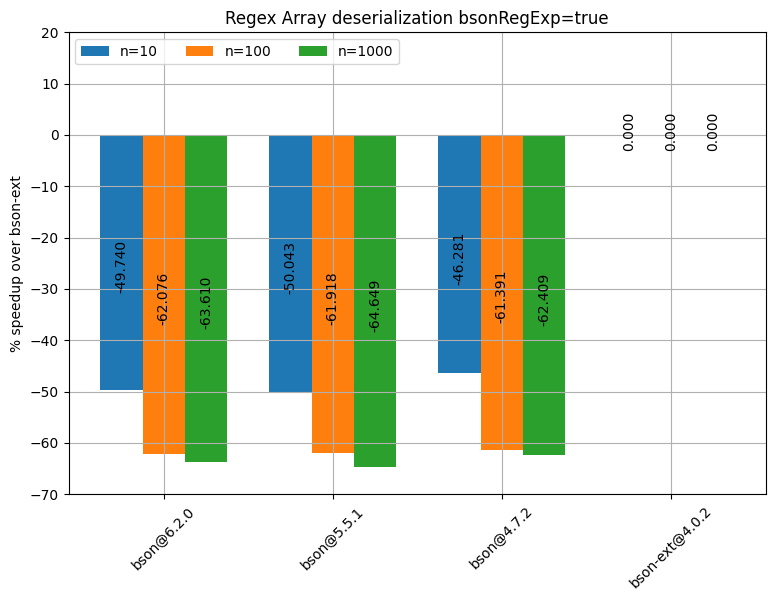

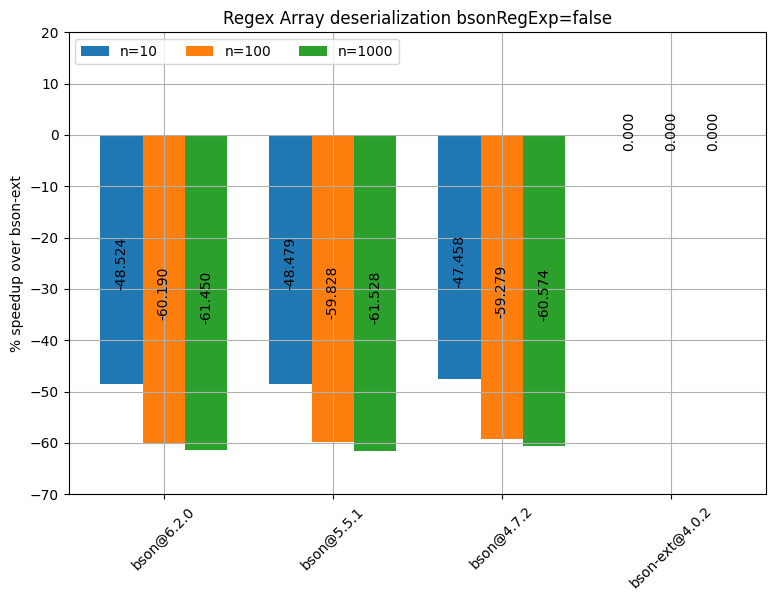

In [377]:
# Regex deserialize
regexResults = documents['regexResults.csv']
createSimpleGraphPct(regexResults, '_singleFieldDocument._deserialize', 'Regex Single Field Document deserialization bsonRegExp=true', bsonRegExp='1')
createSimpleGraphPct(regexResults, '_singleFieldDocument._deserialize', 'Regex Single Field Document deserialization bsonRegExp=false', bsonRegExp='0')

createSimpleGraphPct(regexResults, '_singleElementArray._deserialize', 'Regex Single Element Array deserialization bsonRegExp=true', bsonRegExp='1')
createSimpleGraphPct(regexResults, '_singleElementArray._deserialize', 'Regex Single Element Array bsonRegExp=false', bsonRegExp='0')

createArrayGraphPct(regexResults, 'deserialize', f'Regex Array deserialization bsonRegExp=true', bsonRegExp='1', ylim0=-70, ylim1=20)
createArrayGraphPct(regexResults, 'deserialize', f'Regex Array deserialization bsonRegExp=false', bsonRegExp='0', ylim0=-70, ylim1=20)

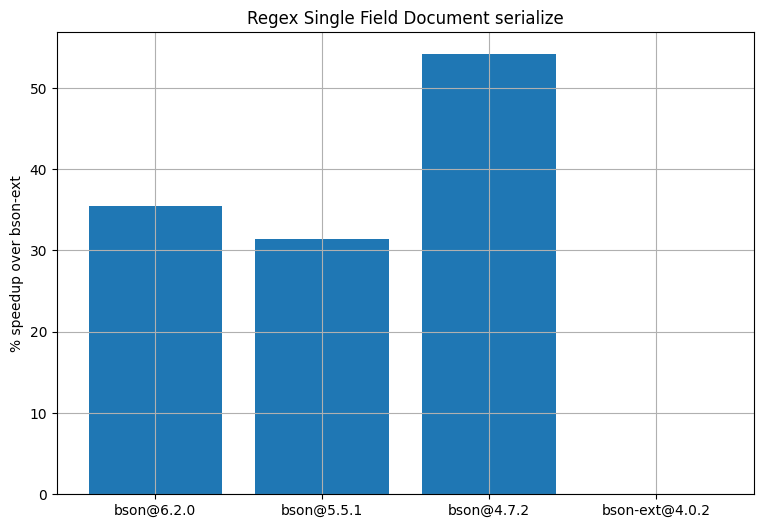

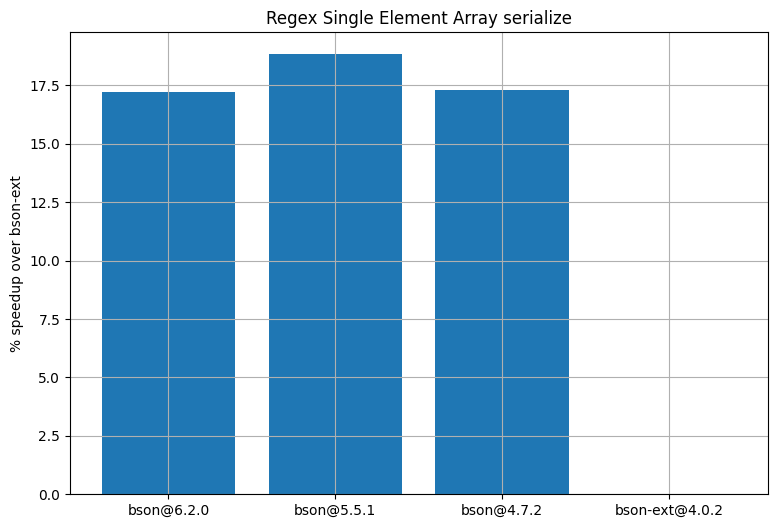

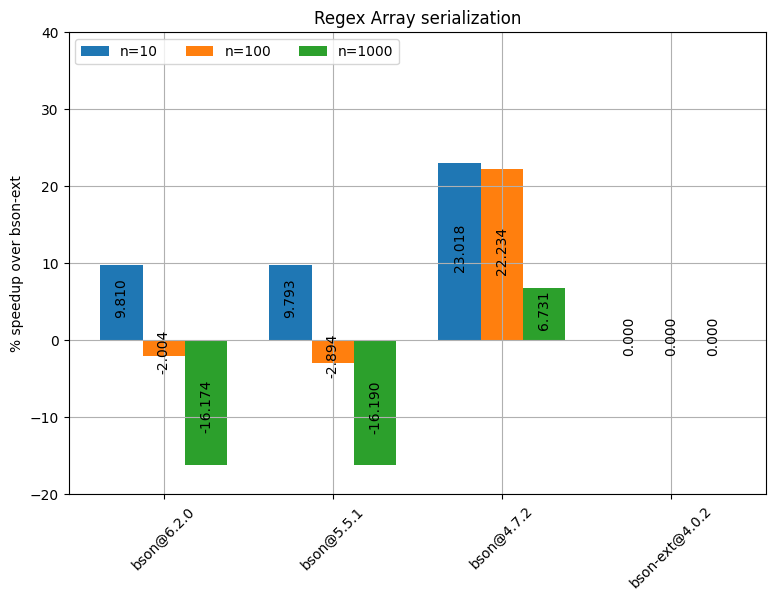

In [378]:
# Regex serialize
regexResults = documents['regexResults.csv']
createSimpleGraphPct(regexResults, '_singleFieldDocument._serialize', 'Regex Single Field Document serialize')

createSimpleGraphPct(regexResults, '_singleElementArray._serialize', 'Regex Single Element Array serialize')

createArrayGraphPct(df, 'serialize', f'Regex Array serialization', ylim1=40, ylim0=-20)

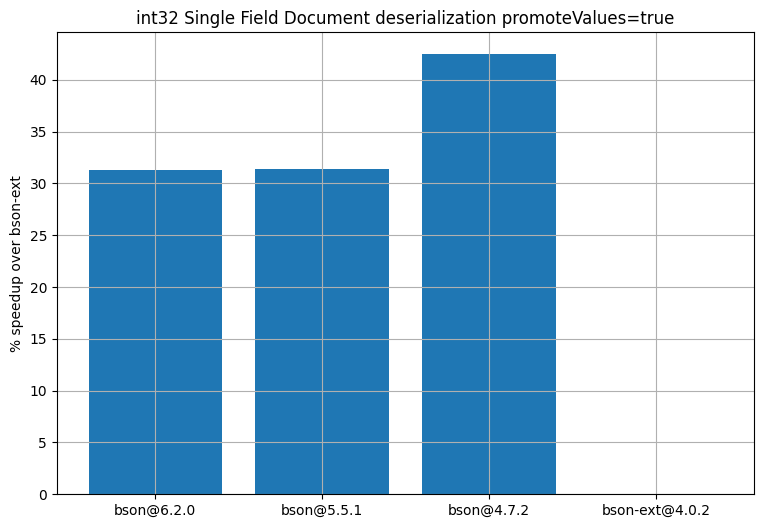

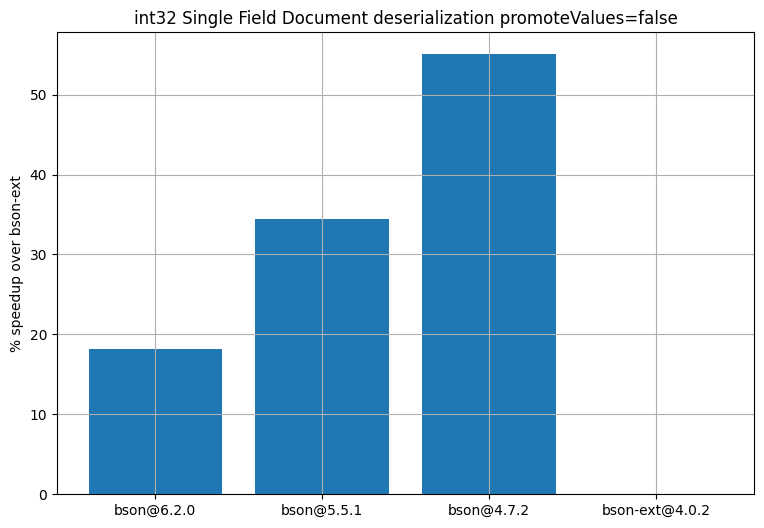

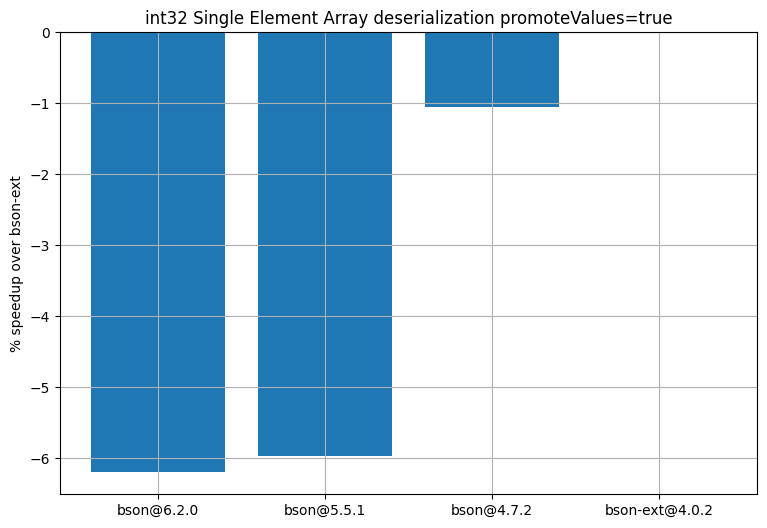

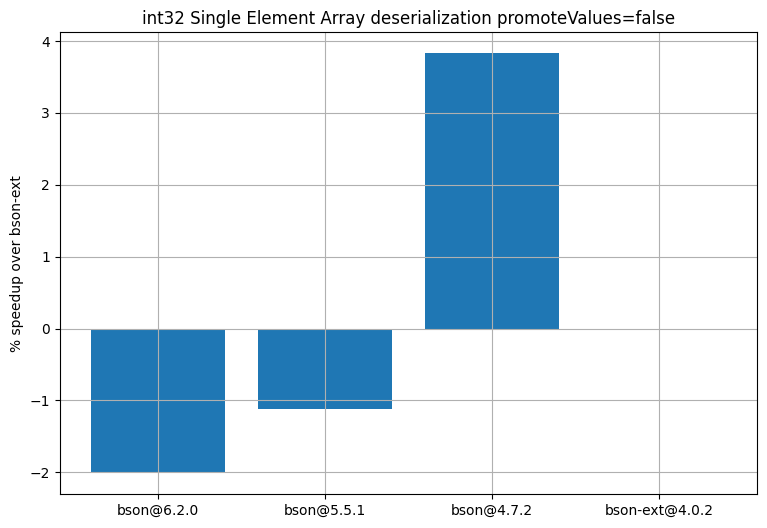

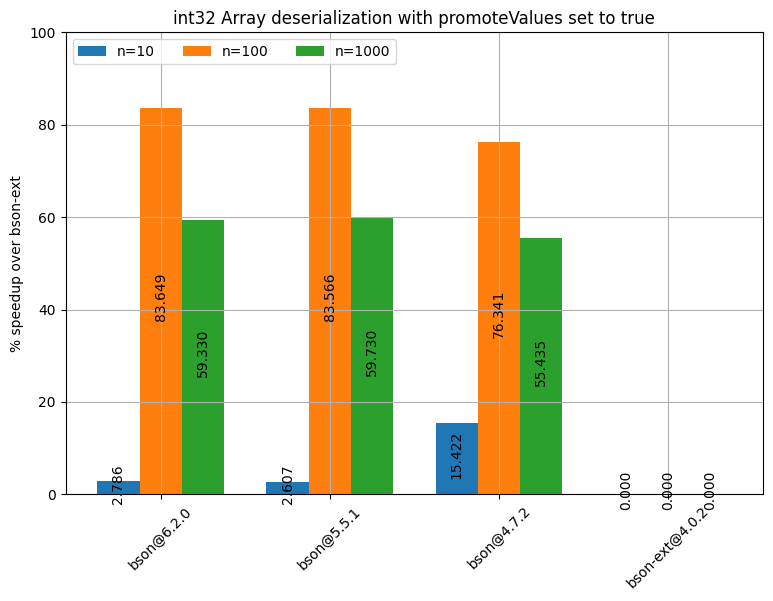

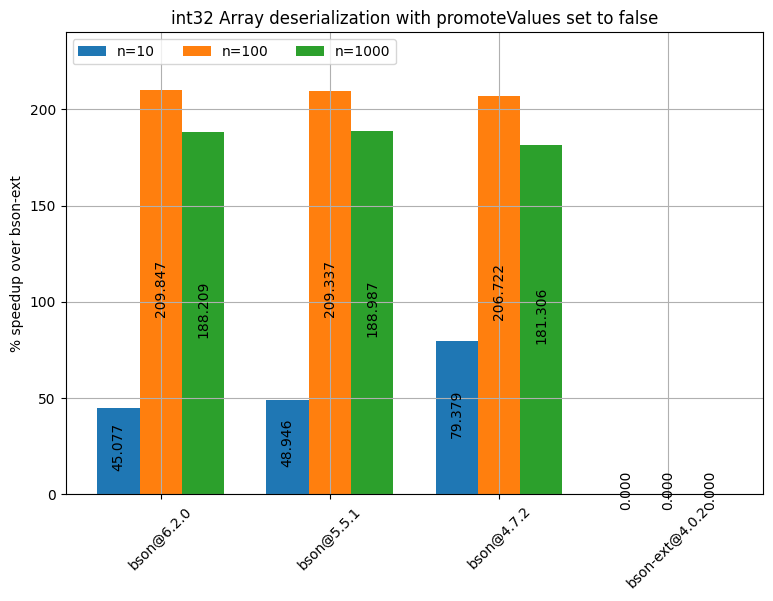

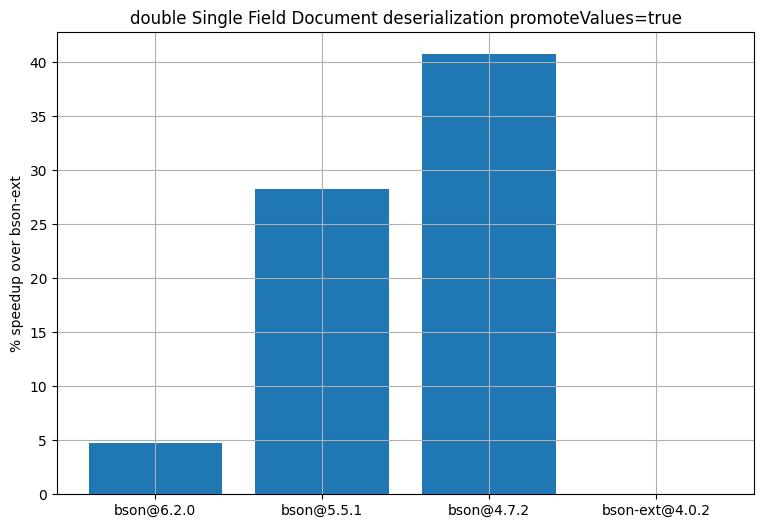

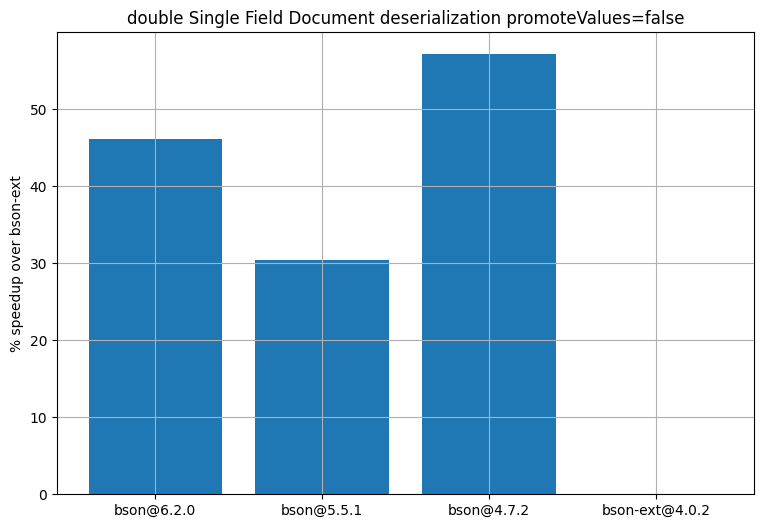

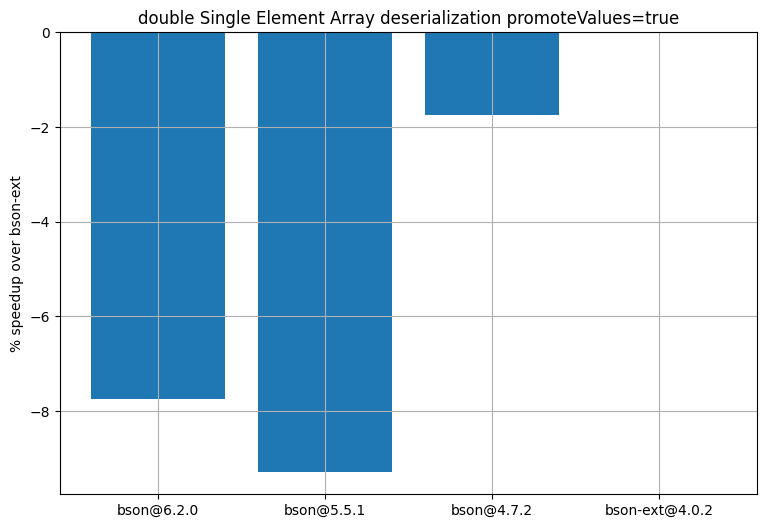

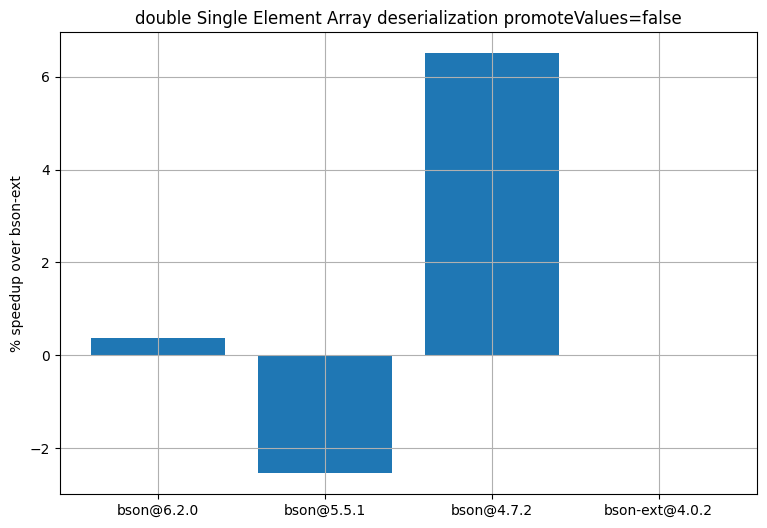

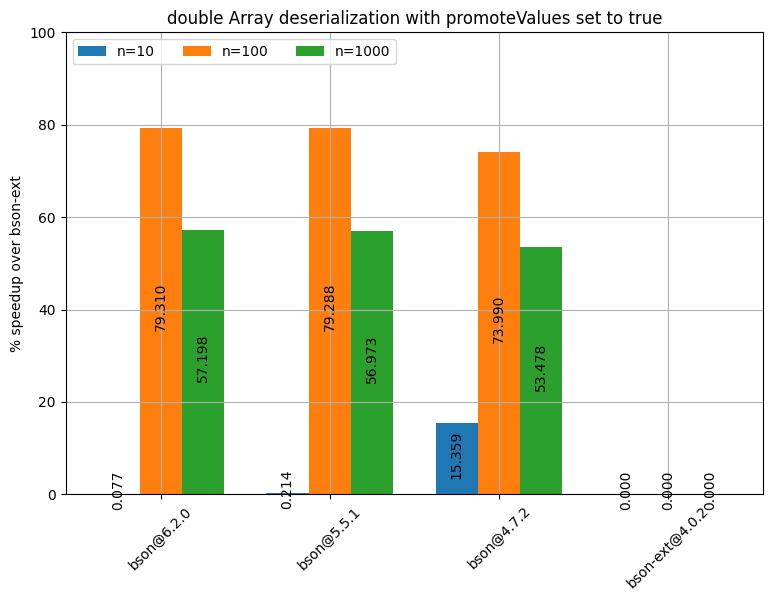

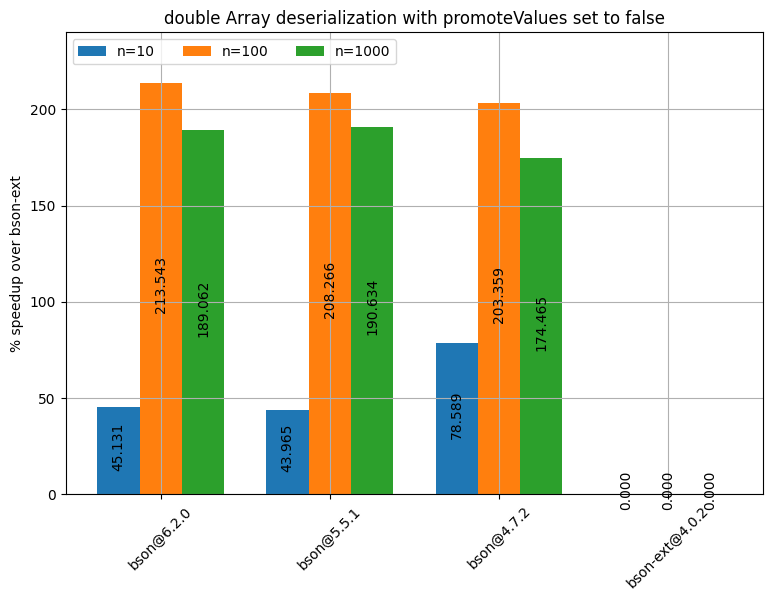

In [331]:
for t in ['int32', 'double']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraphPct(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization promoteValues=true', promoteValues='1')
    createSimpleGraphPct(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization promoteValues=false', promoteValues='0')
    
    createSimpleGraphPct(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization promoteValues=true', promoteValues='1')
    createSimpleGraphPct(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization promoteValues=false', promoteValues='0')
    # Create graphs for arrays
    createArrayGraphPct(df, 'deserialize', f'{t} Array deserialization with promoteValues set to true', promoteValues='1', ylim0=0) 
    createArrayGraphPct(df, 'deserialize', f'{t} Array deserialization with promoteValues set to false', promoteValues='0', ylim0=0, ylim1=240) 


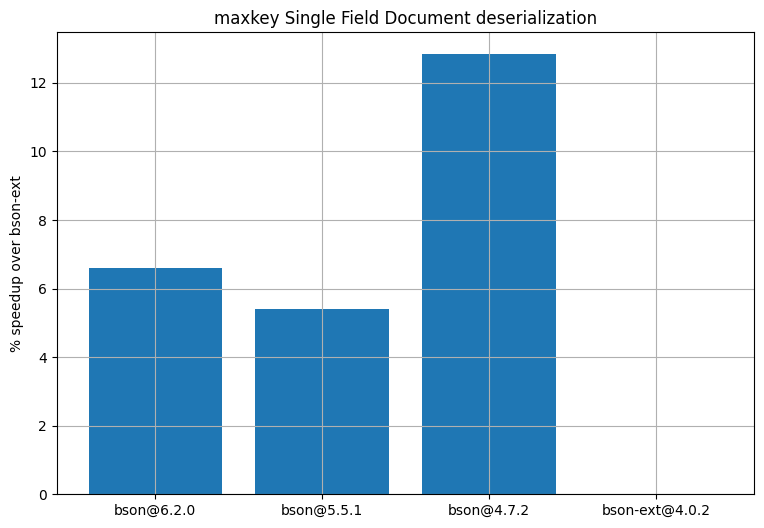

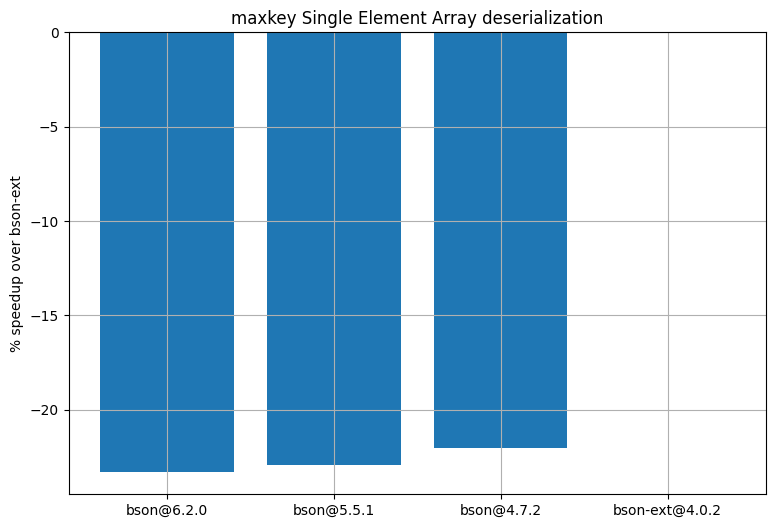

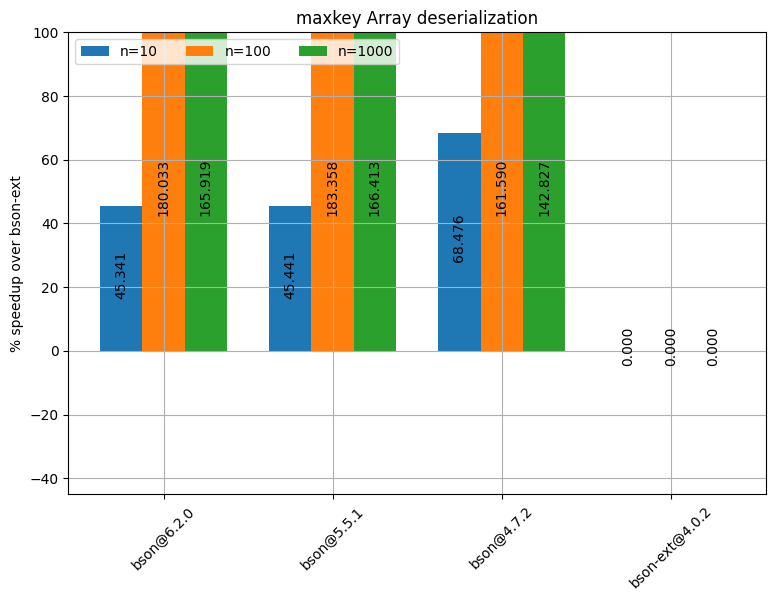

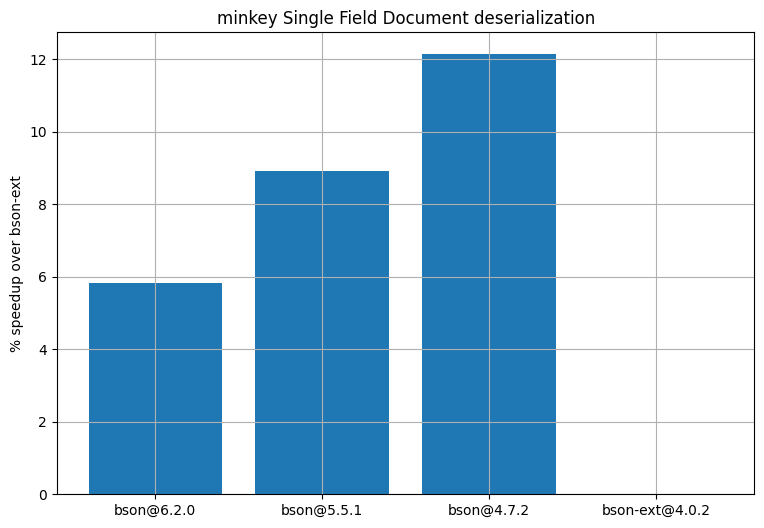

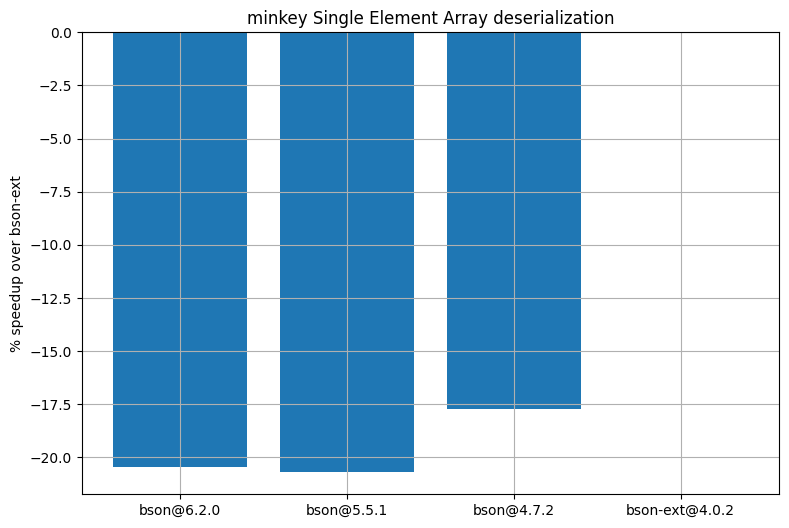

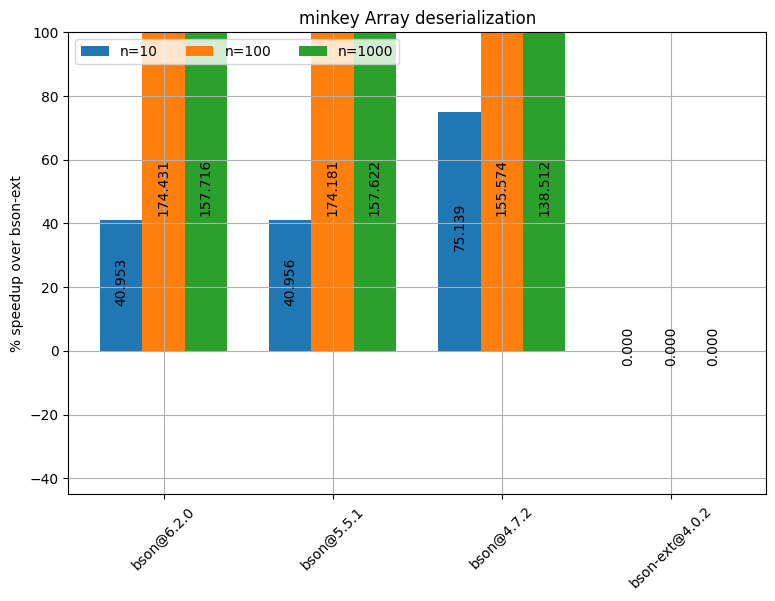

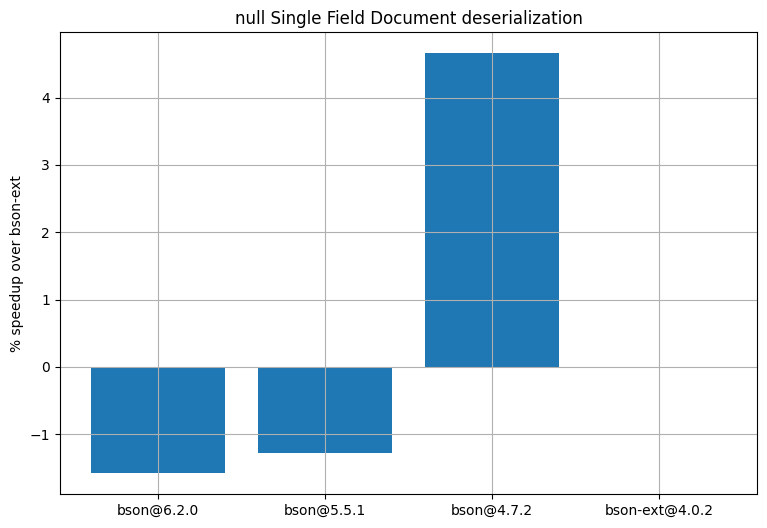

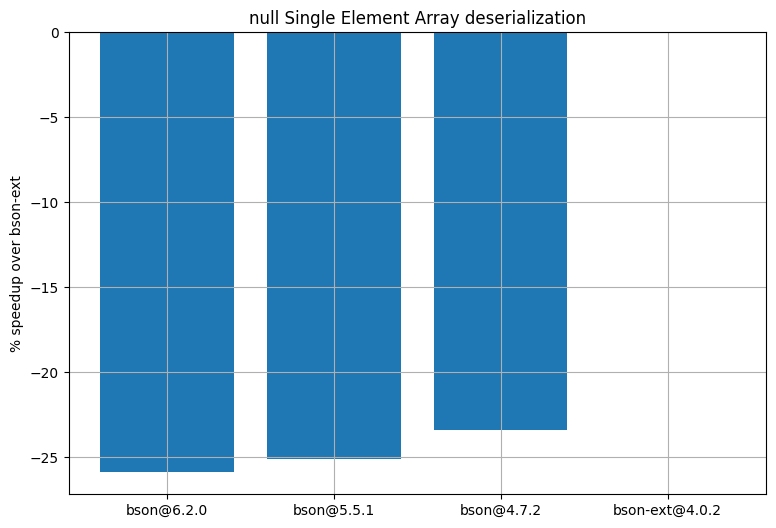

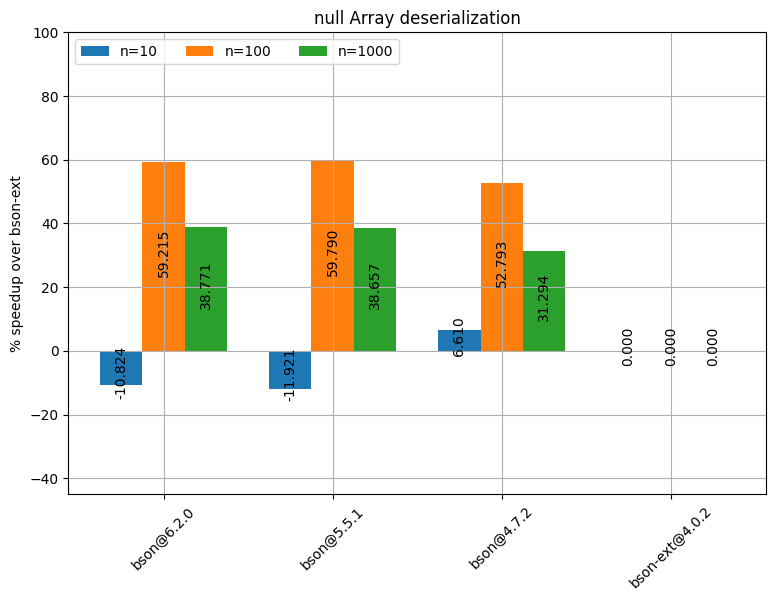

ValueError: dataframe overconstrained

In [332]:
for t in ['maxkey', 'minkey', 'null', 'objectid', 'decimal128']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraphPct(df, '_singleFieldDocument._deserialize', f'{t} Single Field Document deserialization')
    
    createSimpleGraphPct(df, '_singleElementArray._deserialize', f'{t} Single Element Array deserialization')
    # Create graphs for arrays
    createArrayGraphPct(df, 'deserialize', f'{t} Array deserialization')

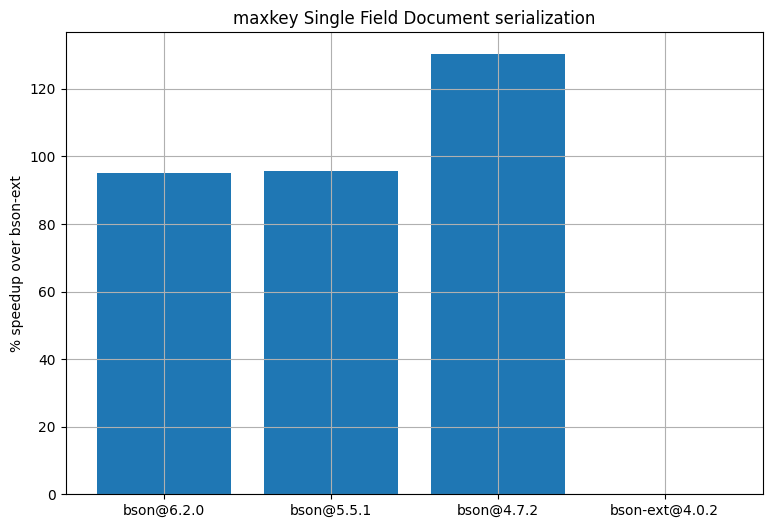

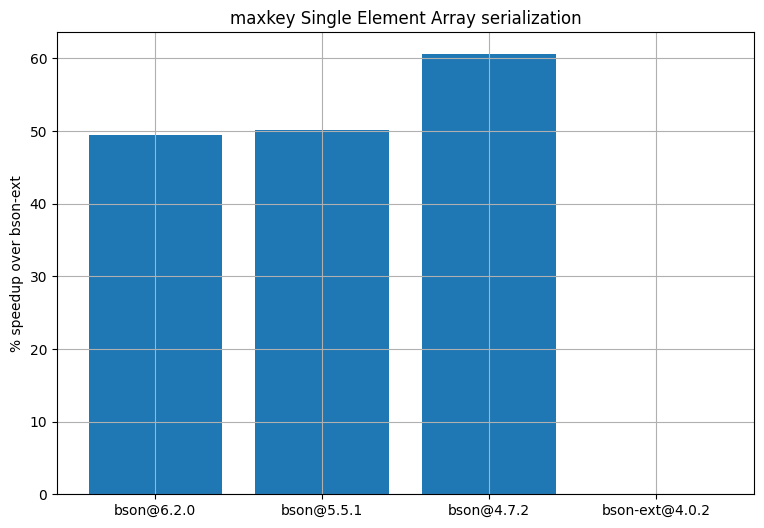

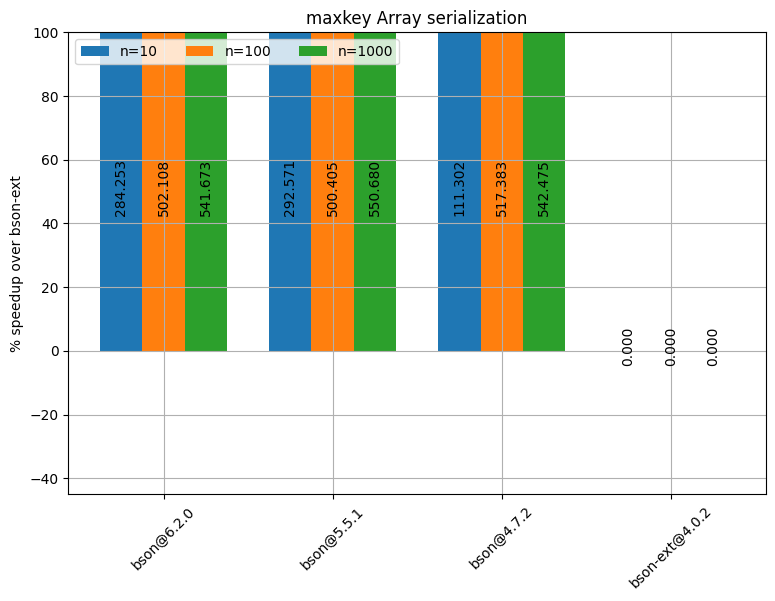

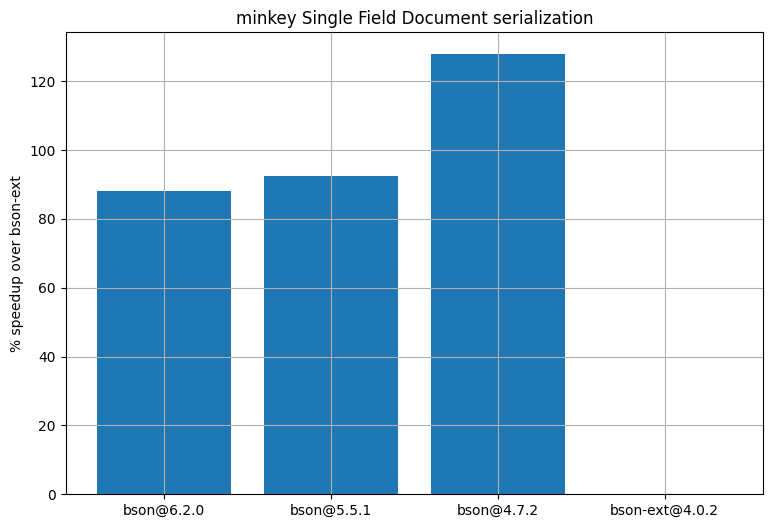

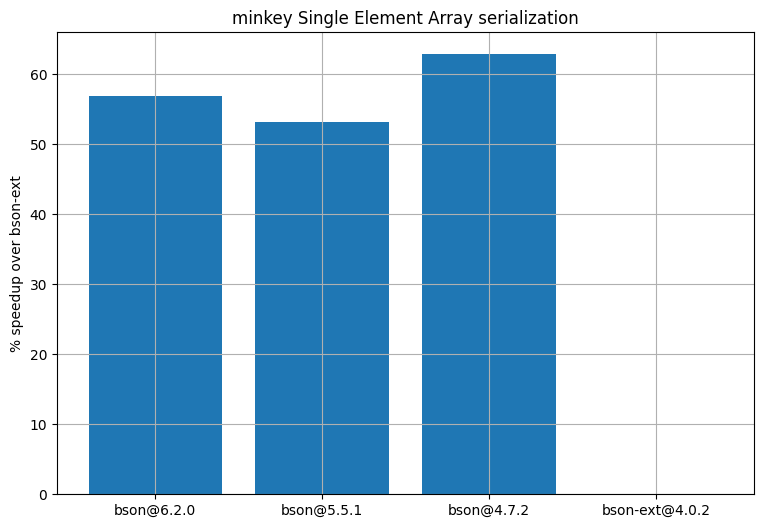

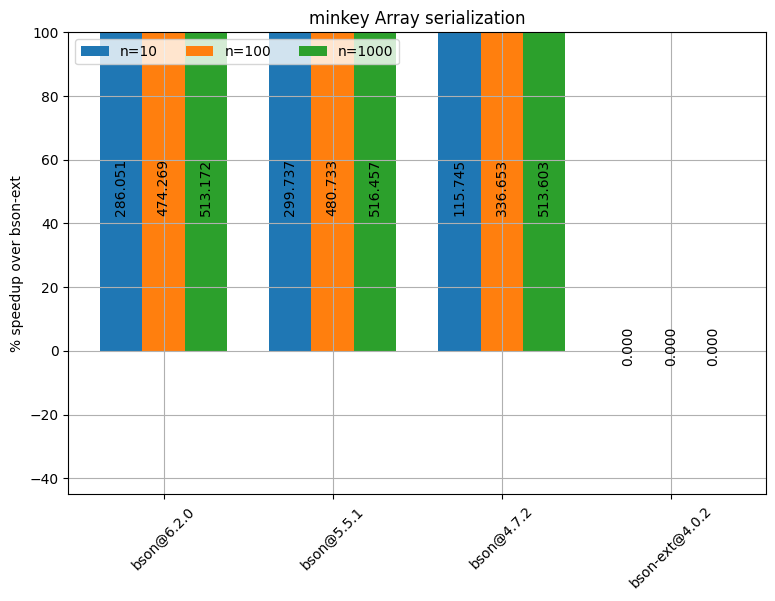

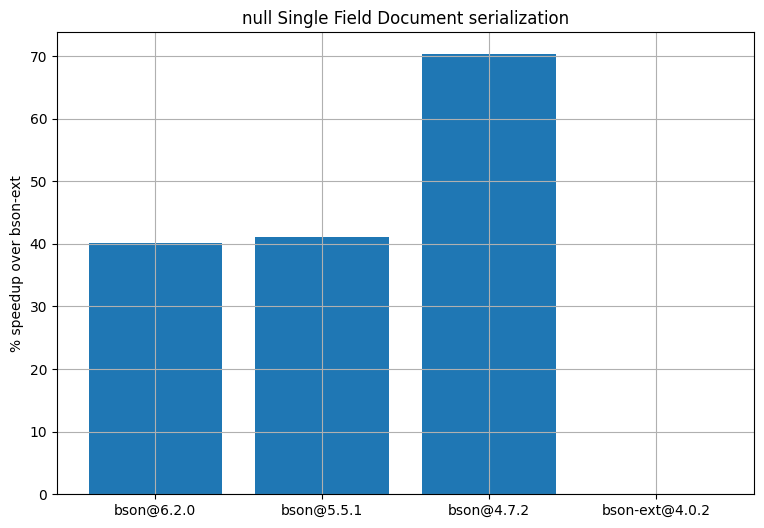

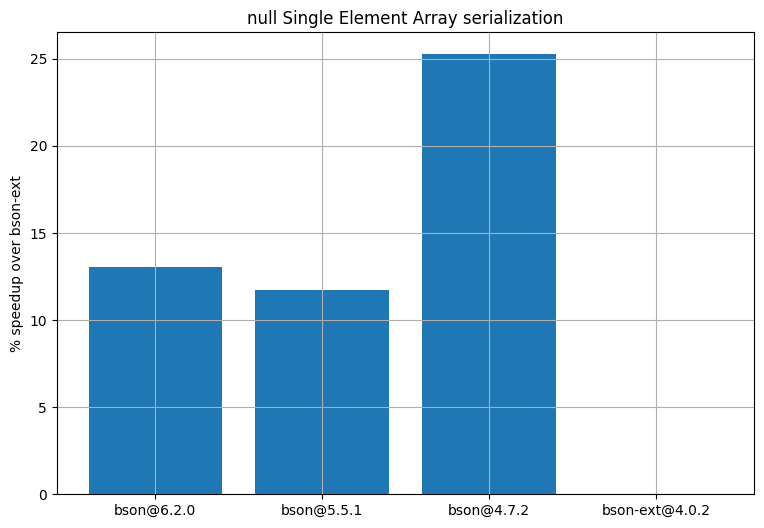

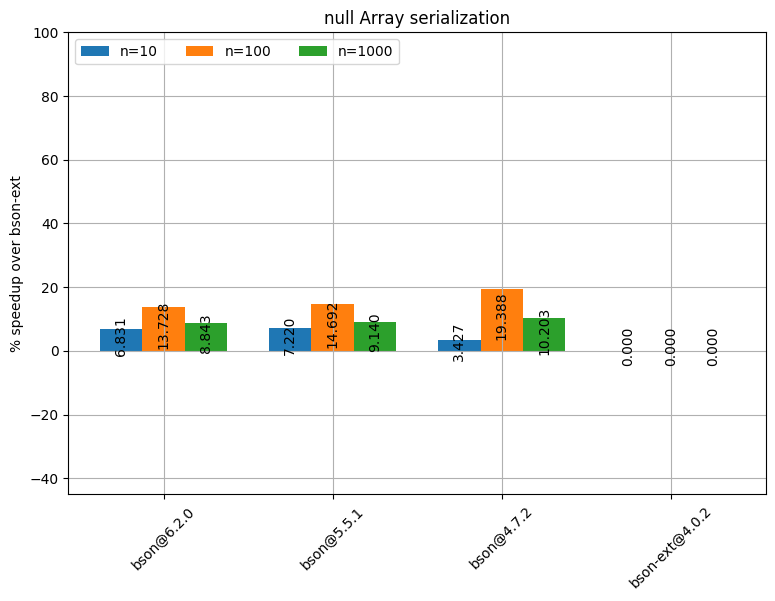

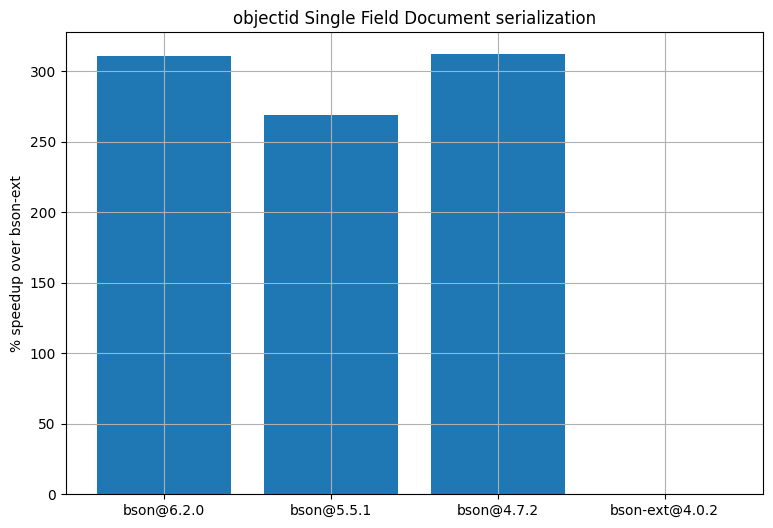

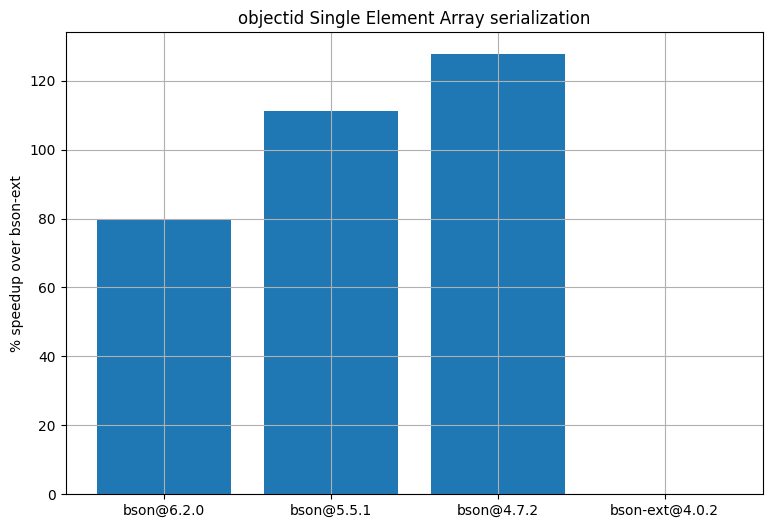

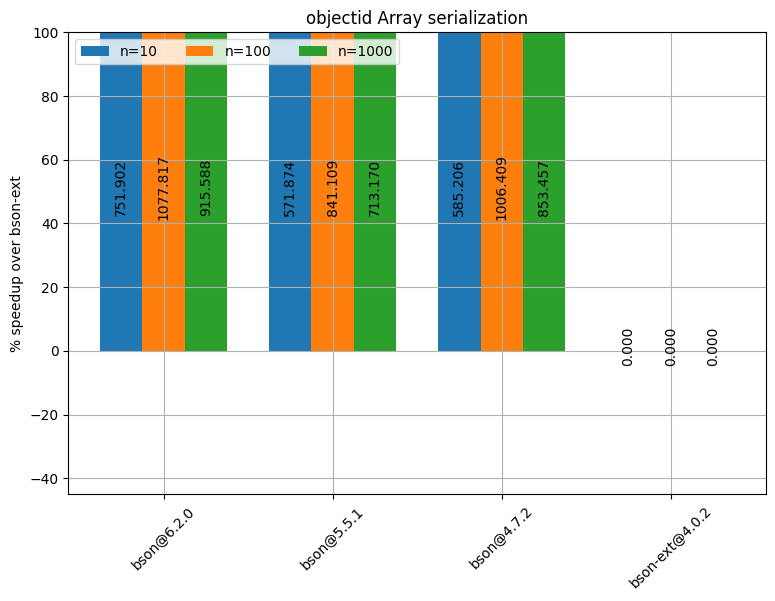

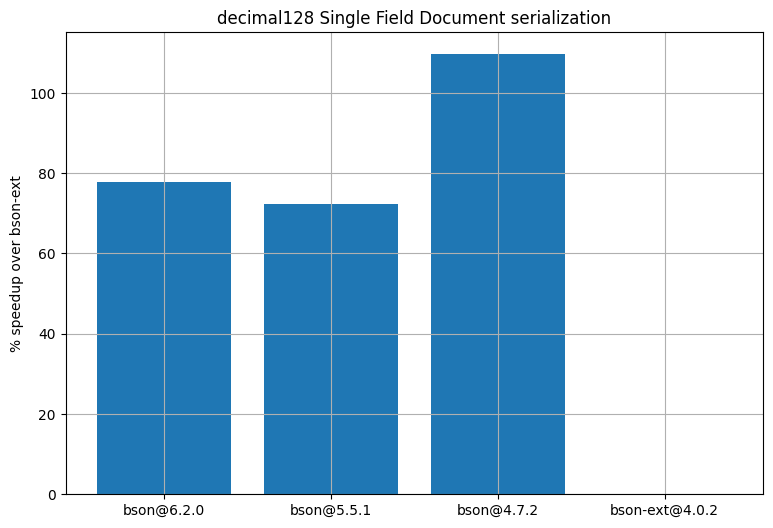

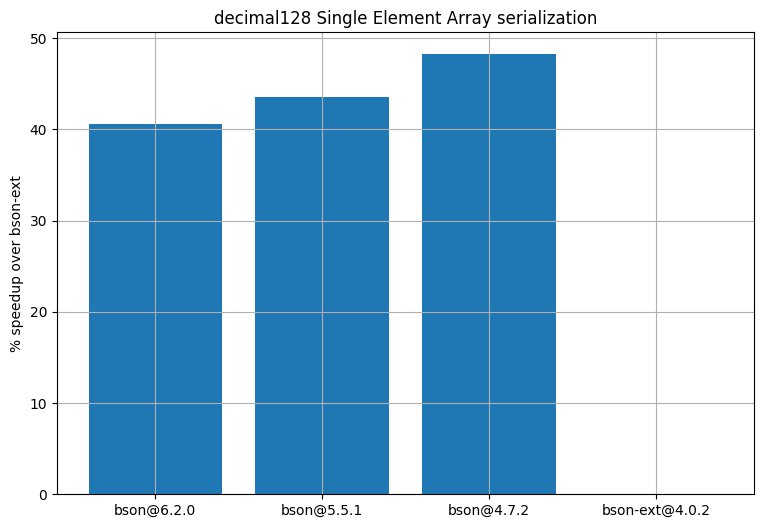

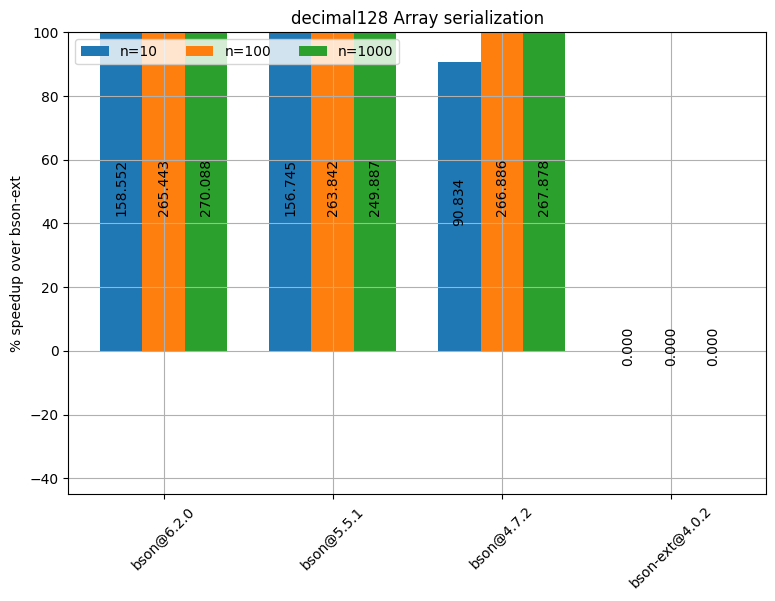

In [333]:
for t in ['maxkey', 'minkey', 'null', 'objectid']:
    df = documents[f'{t}Results.csv']
    
    # Create graphs for sfd and sea docs
    createSimpleGraphPct(df, '_singleFieldDocument._serialize', f'{t} Single Field Document serialization')
    
    createSimpleGraphPct(df, '_singleElementArray._serialize', f'{t} Single Element Array serialization')
    # Create graphs for arrays
    createArrayGraphPct(df, 'serialize', f'{t} Array serialization')
     

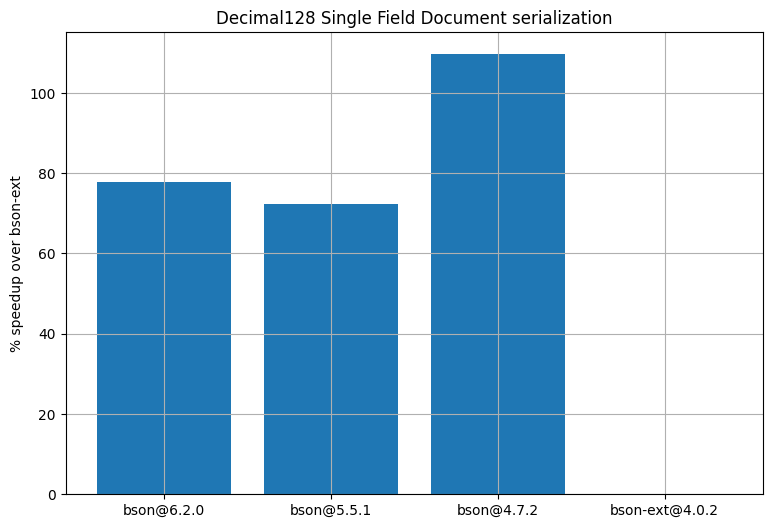

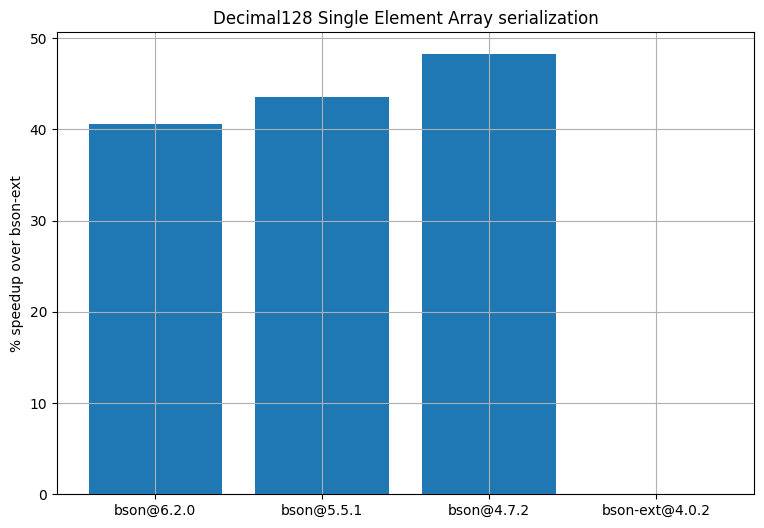

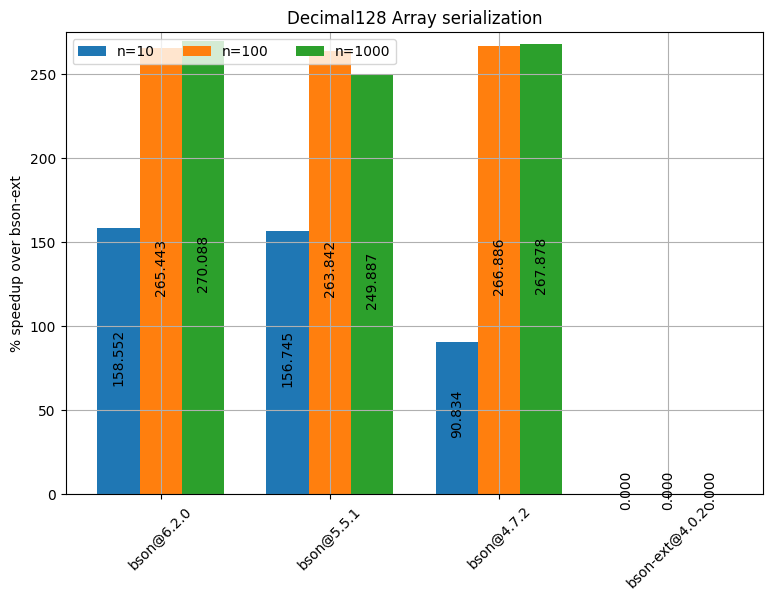

In [374]:
decimal128Results = documents[f'decimal128Results.csv']
    
# Create graphs for sfd and sea docs
createSimpleGraphPct(decimal128Results, '_singleFieldDocument._serialize', f'Decimal128 Single Field Document serialization')

createSimpleGraphPct(decimal128Results, '_singleElementArray._serialize', f'Decimal128 Single Element Array serialization')
# Create graphs for arrays
createArrayGraphPct(decimal128Results, 'serialize', f'Decimal128 Array serialization', ylim0=0, ylim1=275)

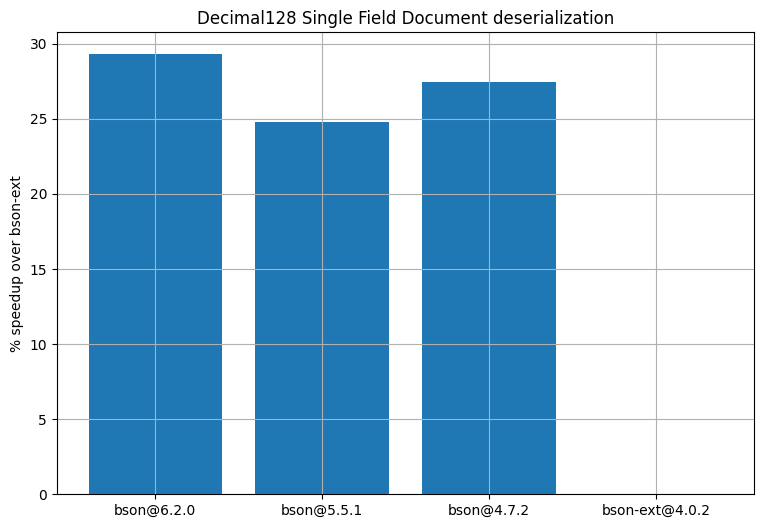

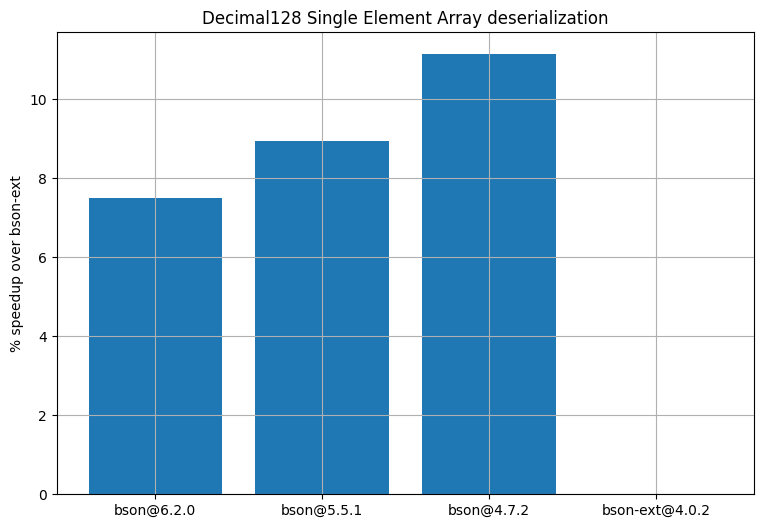

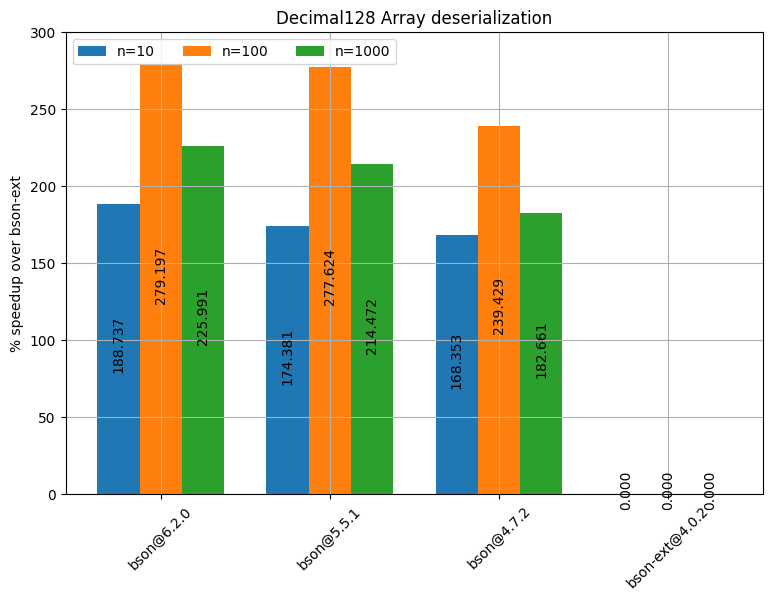

In [376]:
# Create graphs for sfd and sea docs
createSimpleGraphPct(decimal128Results, '_singleFieldDocument._deserialize', f'Decimal128 Single Field Document deserialization')

createSimpleGraphPct(decimal128Results, '_singleElementArray._deserialize', f'Decimal128 Single Element Array deserialization')
# Create graphs for arrays
createArrayGraphPct(decimal128Results, 'deserialize', f'Decimal128 Array deserialization', ylim0=0, ylim1=300)

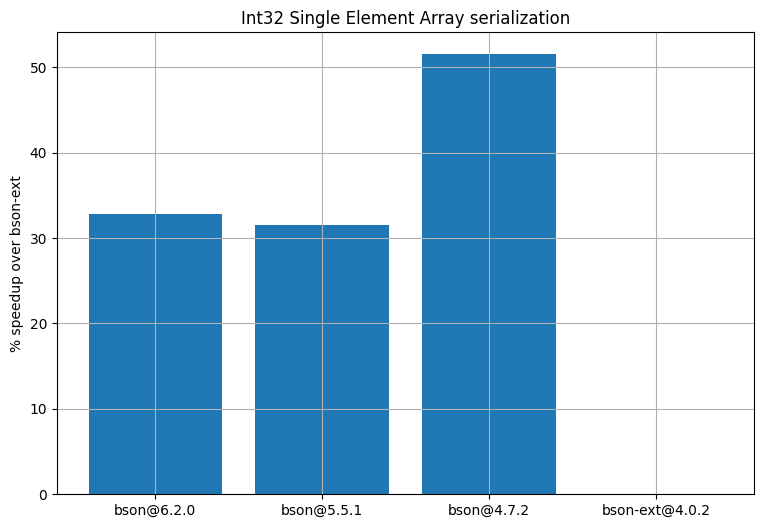

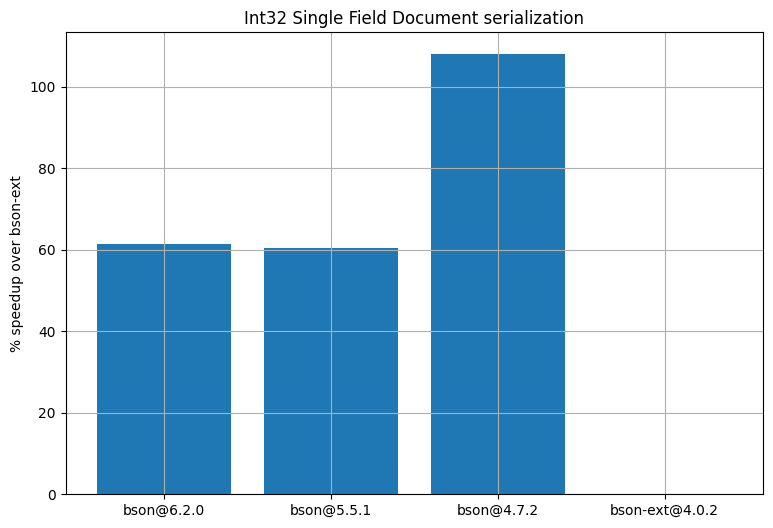

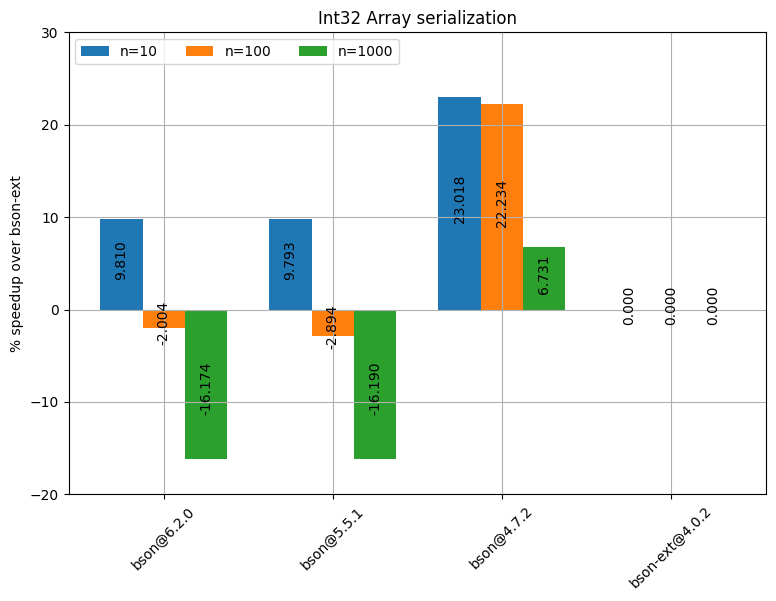

In [379]:
df = documents[f'int32Results.csv']
createSimpleGraphPct(df, '_singleElementArray._serialize', f'Int32 Single Element Array serialization')
createSimpleGraphPct(df, '_singleFieldDocument._serialize', f'Int32 Single Field Document serialization')
createArrayGraphPct(df, 'serialize', 'Int32 Array serialization', ylim0=-20,ylim1=30)

In [335]:
stringResults = documents['stringResults.csv']

bsonExtDeser= stringResults.loc[
                            (stringResults['library'].str.contains('bson-ext')) &
                            (stringResults['test_name'].str.contains('deserialize'))
]

bsonUTF8Disabled = filterFor(stringResults, '_deserialize',utf8Validation='0')

stringResultsUTF8Disabled = pd.concat([bsonUTF8Disabled, bsonExtDeser])


# Deserialize

## Single Field Document

## Single Element Array

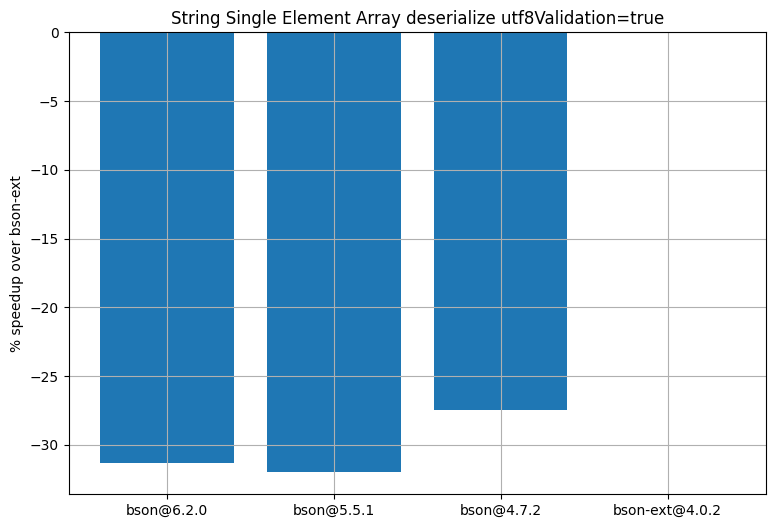

In [336]:
createSimpleGraphPct(stringResults, '_singleElementArray._deserialize', 'String Single Element Array deserialize utf8Validation=true', utf8Validation='1')

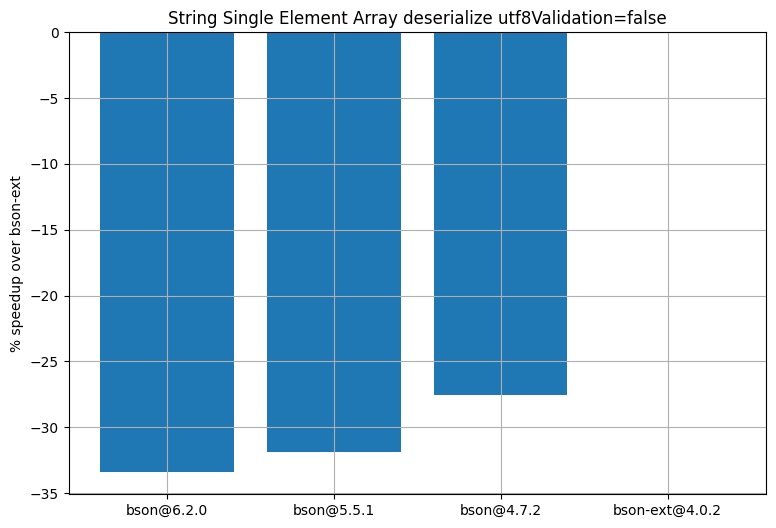

In [337]:
createSimpleGraphPct(stringResultsUTF8Disabled, '_singleElementArray._deserialize', 'String Single Element Array deserialize utf8Validation=false' )

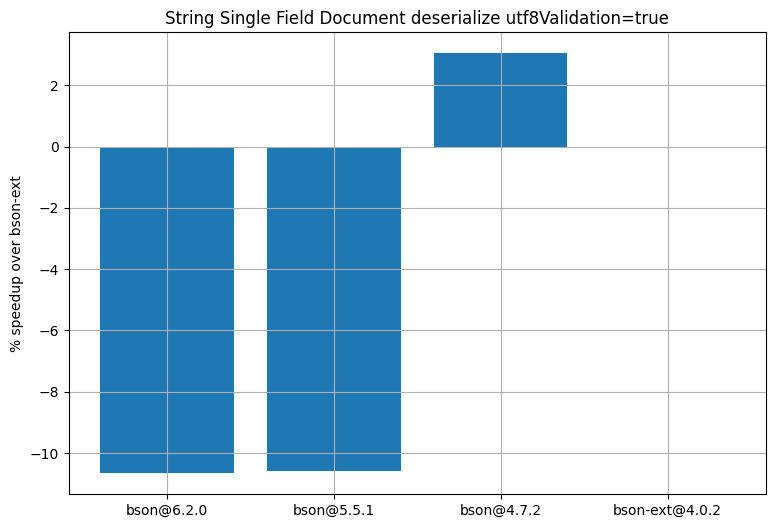

In [338]:
createSimpleGraphPct(stringResults, '_singleFieldDocument._deserialize', 'String Single Field Document deserialize utf8Validation=true', utf8Validation='1')

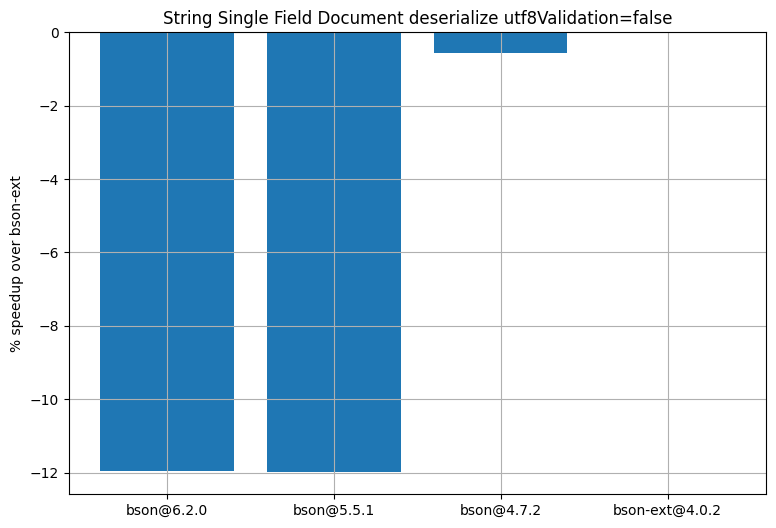

In [339]:
createSimpleGraphPct(stringResultsUTF8Disabled, '_singleFieldDocument._deserialize', 'String Single Field Document deserialize utf8Validation=false' )

### Array

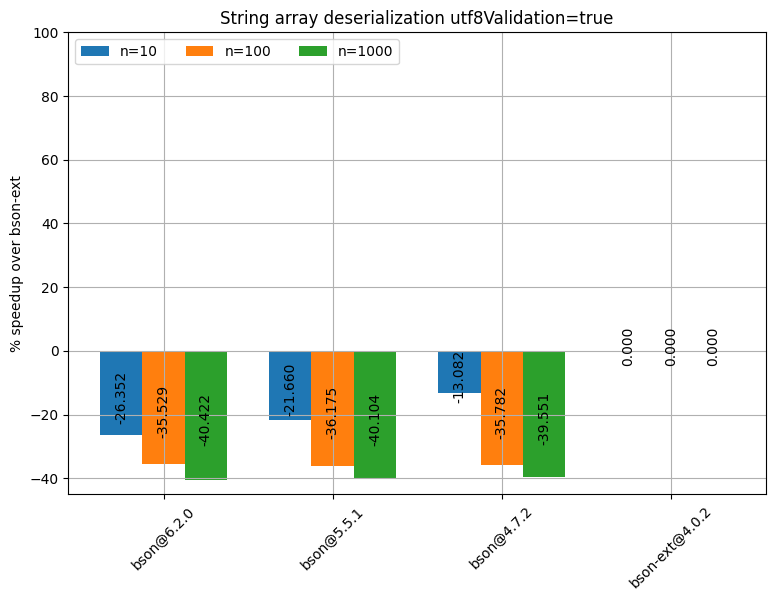

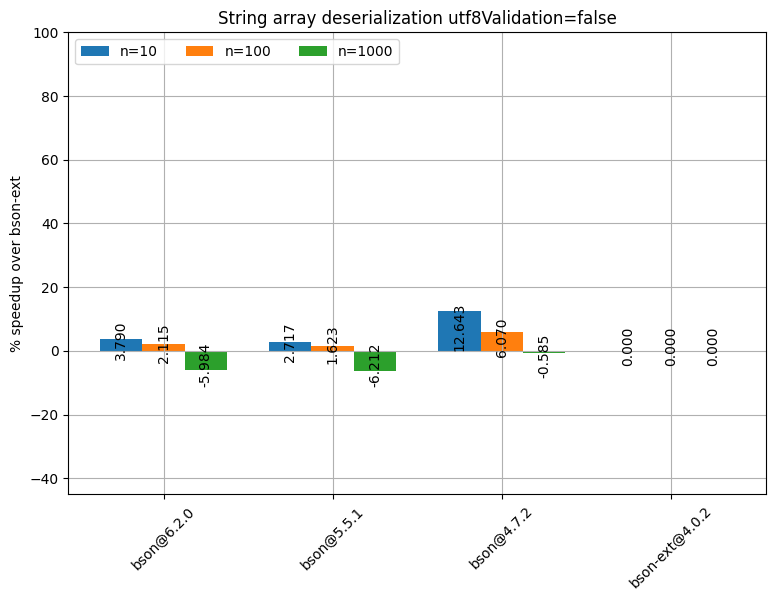

In [340]:
createArrayGraphPct(stringResults, 'deserialize', 'String array deserialization utf8Validation=true', utf8Validation='1')
createArrayGraphPct(stringResultsUTF8Disabled, 'deserialize', 'String array deserialization utf8Validation=false')

## Serialize

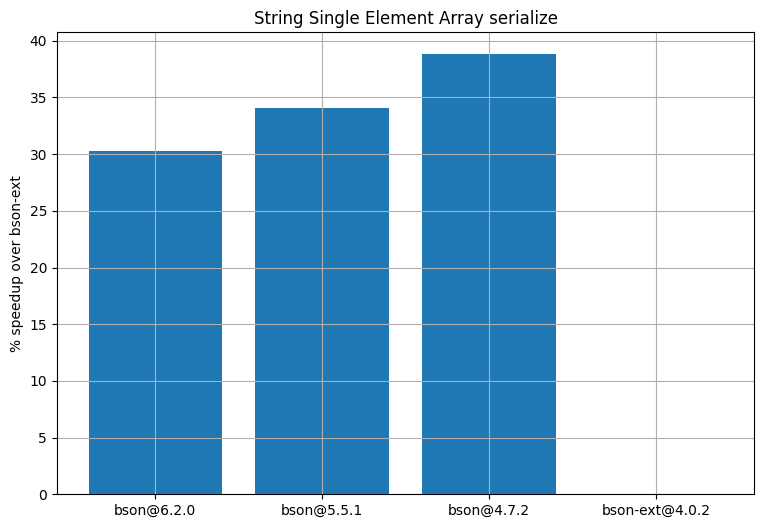

In [341]:
### Single element Array
createSimpleGraphPct(stringResults, '_singleElementArray._serialize', 'String Single Element Array serialize')

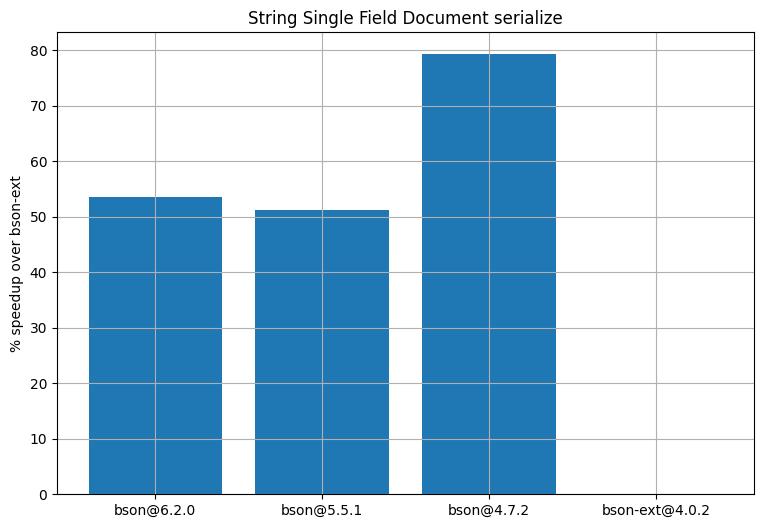

In [342]:
### Single field document
createSimpleGraphPct(stringResults, '_singleFieldDocument._serialize', 'String Single Field Document serialize')

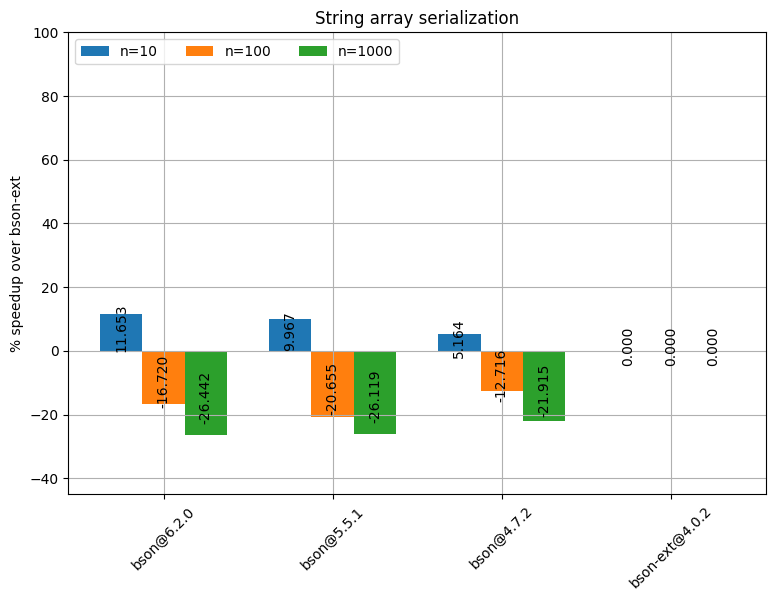

In [343]:
### Array
createArrayGraphPct(stringResults, 'serialize', 'String array serialization')

# Mixed Document Tests

In [ ]:
## Tweet

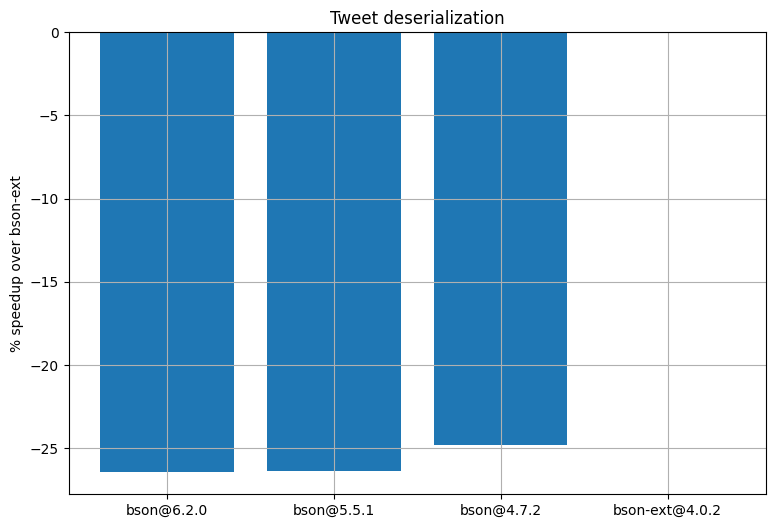

In [344]:
mixedResults = documents['mixedDocumentsResults.csv']

# Tweet and bestbuy_medium
mediumDocs = mixedResults.loc[
    (
    (mixedResults['test_name'].str.contains('tweet')) |
    (mixedResults['test_name'].str.contains('bestbuy'))
    ) & (mixedResults['test_name'].str.contains('._deserialize'))
]


createSimpleGraphPct(mediumDocs, 'tweet._deserialize', 'Tweet deserialization')

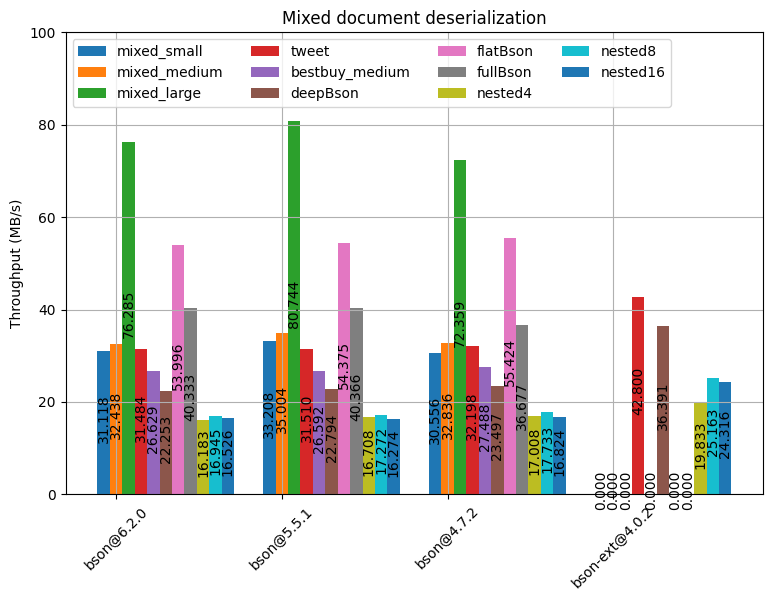

In [393]:
createMixedGraphs(mixedResults, 'deserialize', 'Mixed document deserialization')

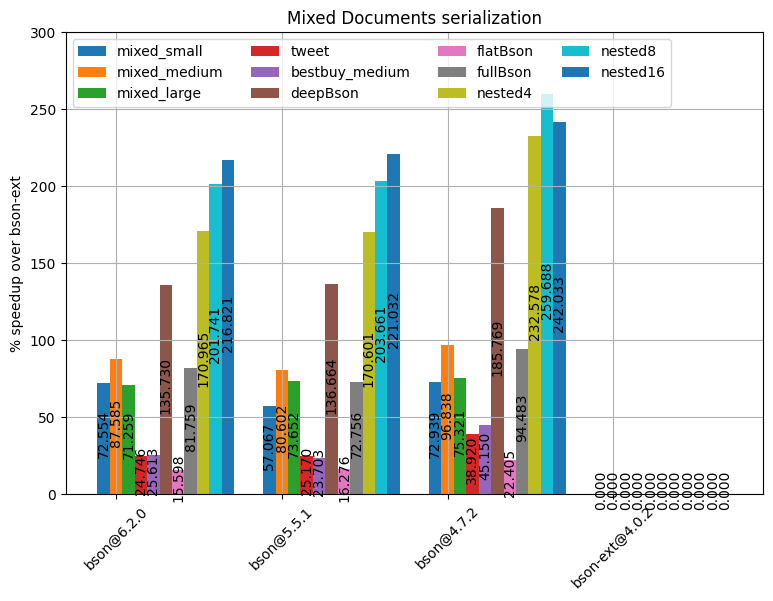

In [399]:
createMixedGraphsPct(mixedResults, 'serialize', 'Mixed Documents serialization', ylim1=300)

In [ ]:
nestedResults = 

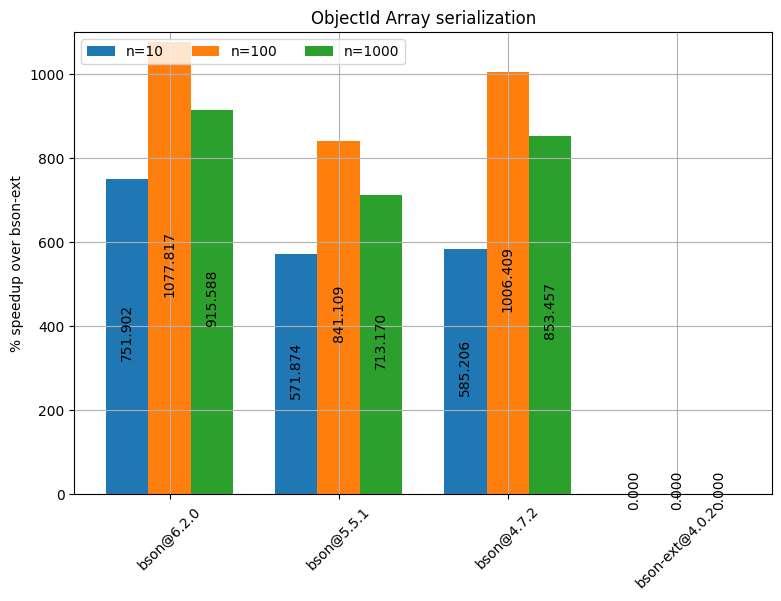

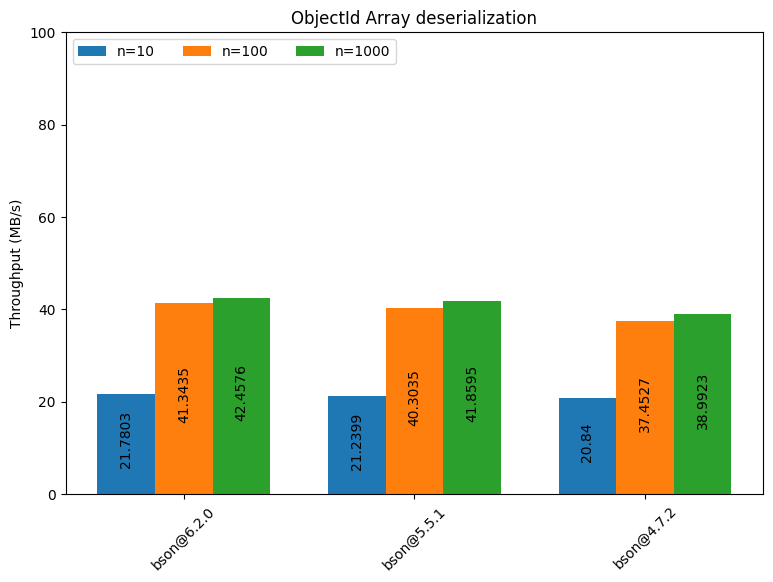

In [360]:
objectId = documents['objectidResults.csv']

createArrayGraphPct(objectId, 'serialize', 'ObjectId Array serialization', ylim0=0, ylim1=1100)

createArrayGraph(objectId, 'deserialize', 'ObjectId Array deserialization')

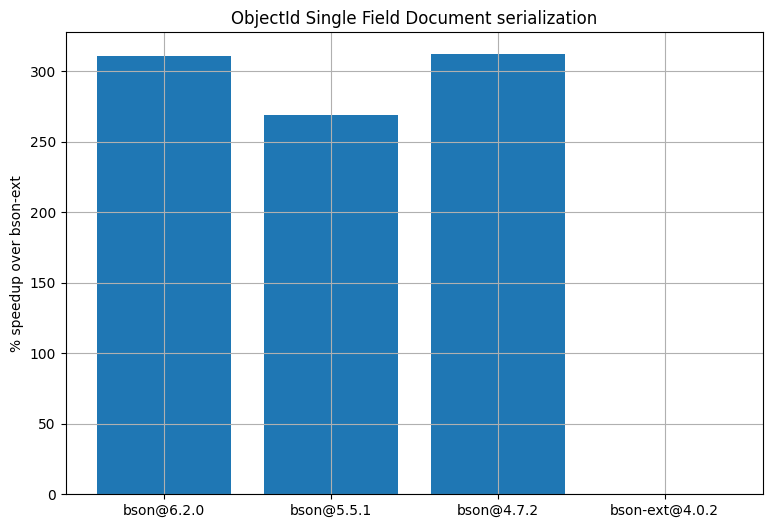

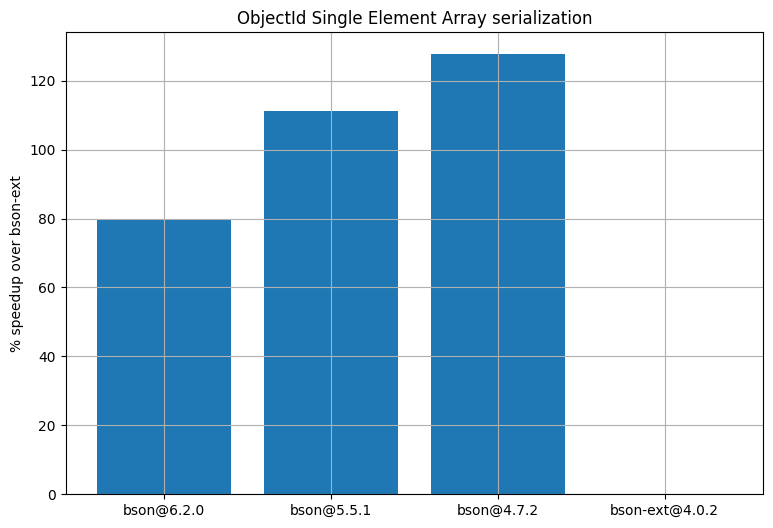

In [361]:
createSimpleGraphPct(objectId, 'singleFieldDocument._serialize', 'ObjectId Single Field Document serialization')
createSimpleGraphPct(objectId, 'singleElementArray._serialize', 'ObjectId Single Element Array serialization')

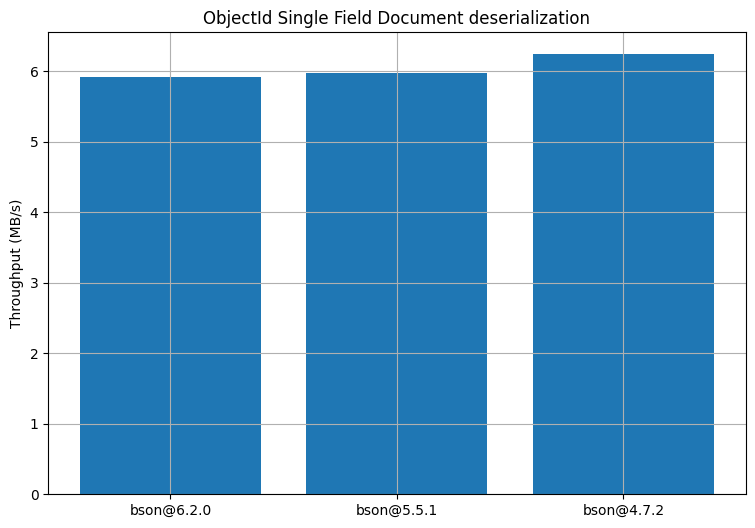

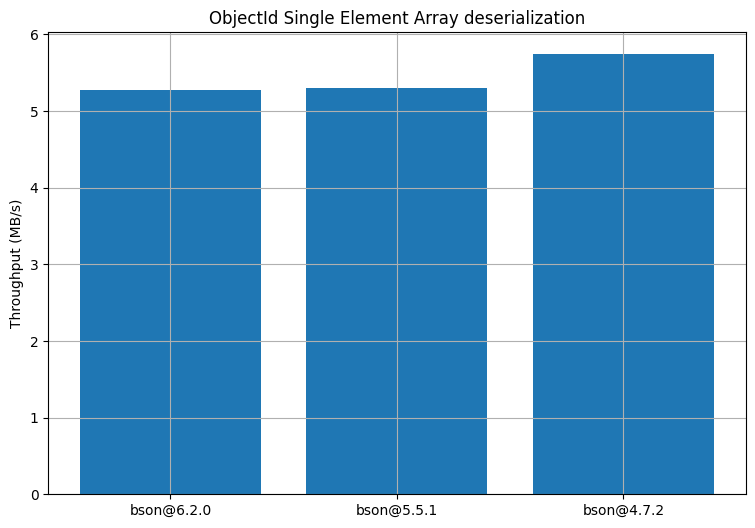

In [362]:
createSimpleGraph(objectId, 'singleFieldDocument._deserialize', 'ObjectId Single Field Document deserialization')
createSimpleGraph(objectId, 'singleElementArray._deserialize', 'ObjectId Single Element Array deserialization')

In [391]:
mixedResults[mixedResults['test_name'].str.contains('nested')]

test_name         library        max       mean     median  \
8      nested_4._serialize      bson@6.2.0  21.862105  20.295588  21.220570   
9      nested_8._serialize      bson@6.2.0  24.361431  23.643662  24.058342   
10    nested_16._serialize      bson@6.2.0  23.836998  23.670913  23.654490   
19   nested_4._deserialize      bson@6.2.0  16.801772  16.183424  16.487942   
20   nested_8._deserialize      bson@6.2.0  17.681936  16.945110  17.397923   
21  nested_16._deserialize      bson@6.2.0  17.018774  16.525874  16.404318   
30     nested_4._serialize      bson@5.5.1  22.003360  20.268370  21.226085   
31     nested_8._serialize      bson@5.5.1  24.538573  23.794170  24.246851   
32    nested_16._serialize      bson@5.5.1  24.148181  23.985584  23.969507   
41   nested_4._deserialize      bson@5.5.1  17.286192  16.707701  16.998524   
42   nested_8._deserialize      bson@5.5.1  17.983449  17.271917  17.713769   
43  nested_16._deserialize      bson@5.5.1  16.775736  16.274323  16.160149   
52     nested_4._serialize      bson@4.7.2  25.992940  24.910523  25.436903   
53     nested_8._serialize      bson@4.7.2  29.026481  28.184272  28.523081   
54    nested_16._serialize      bson@4.7.2  26.155009  25.554618  25.532046   
63   nested_4._deserialize      bson@4.7.2  17.590274  17.007501  17.294011   
64   nested_8._deserialize      bson@4.7.2  18.458420  17.733111  18.195096   
65  nested_16._deserialize      bson@4.7.2  17.293031  16.824379  16.701495   
74     nested_4._serialize  bson-ext@4.0.2   7.811003   7.490124   7.634911   
75     nested_8._serialize  bson-ext@4.0.2   8.208565   7.835756   7.941906   
76    nested_16._serialize  bson-ext@4.0.2   7.730529   7.471388   7.504244   
79   nested_4._deserialize  bson-ext@4.0.2  21.218200  19.833028  20.864462   
80   nested_8._deserialize  bson-ext@4.0.2  26.043963  25.163420  25.665877   
81  nested_16._deserialize  bson-ext@4.0.2  25.336789  24.316500  24.294345   

          min    stddev  warmup  iterations checkKeys ignoreUndefined  \
8    1.089495  2.151741    1000        1000         1               0   
9   10.767836  1.511308    1000        1000         1               0   
10  23.575017  0.056525    1000        1000         1               0   
19   1.241244  1.345824    1000        1000         -               -   
20   9.537737  1.489315    1000        1000         -               -   
21  14.815019  0.367489    1000        1000         -               -   
30   2.708077  2.170272    1000        1000         1               0   
31  10.807001  1.566318    1000        1000         1               0   
32  23.831544  0.056485    1000        1000         1               0   
41   1.176475  1.321615    1000        1000         -               -   
42  10.200903  1.393564    1000        1000         -               -   
43  14.587708  0.358521    1000        1000         -               -   
52  10.100651  1.932474    1000        1000         1               0   
53  18.292521  0.792528    1000        1000         1               0   
54  24.422614  0.296211    1000        1000         1               0   
63   1.274515  1.340055    1000        1000         -               -   
64  10.153241  1.461631    1000        1000         -               -   
65  15.138996  0.395705    1000        1000         -               -   
74   1.200465  0.548446    1000        1000         1               0   
75   5.580256  0.445941    1000        1000         1               0   
76   7.013367  0.170465    1000        1000         1               0   
79   1.349642  1.937118    1000        1000         -               -   
80  10.736084  1.625852    1000        1000         -               -   
81  23.206234  0.980194    1000        1000         -               -   

   promoteValues index    stderr  
8              -     -  0.068044  
9              -     -  0.047792  
10             -     -  0.001787  
19             1     0  0.042559  
20             1     0  0.047096  
21   